NOTES : 

- Single dataset doens't work at 
    - movie plot
    - spatial decay fit

- If there is a single BG image, 2D-1D plot sample doesn't work

- Add errorbars for delta_rho / rho by using error in rho

In [1]:
# Imports 
import numpy as np
import pandas as pd
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import ipywidgets
import warnings
warnings.filterwarnings("ignore")
import scipy.interpolate
from IPython.display import display, Javascript
import os
import shutil
import mpmath


def getNotebookName():
    display(Javascript('IPython.notebook.kernel.execute("theNotebook = " + "\'"+IPython.notebook.notebook_name+"\'");'))
    return theNotebook

cst = tp.cst()
twopi = 2 * np.pi
kHz = 1e3 * cst.h

Updating the local database...
Done


In [24]:
# Constants 
import_params = ['ExpansionTime','SideGreenEvap','WaitBox',
               'IREvap','HeatTime','ShakeWait', 'HeatCycles',
               'ShakingCycles', 'BoxShakeFreq','BoxShakeAmp','BoxShakeTime',
               'ShakingCycles2', 'BoxShakeFreq2', 'BoxShakeTime2', 'BoxShakeAmp2',
               'SeqMode','GradientOffset','GradientShakeAmp','GradientShakeFreq','GradientShakeCycle',
                'YellowShakeAmplitude','YellowRamp',]

default_settings = dict(
   # Image Preparation and Background 
   center_x=1110, center_y=1314, width=800, height=800, 
   subsample=3, rotate=0, bg_width=20, bg_order=1, bad_light=0,

   # Physical Parameters
   Isat=77, time=10, pixel=0.7e-6, sigmaf=0.5, trap_f=23.9,
   od_method='table', fudge=1, ellipticity=1,
   
   # Hybrid Preparation
   xsec_extension='default', xsec_slice_width=4, 
   xsec_fit_range=1.75, radial_selection=0.5,
   
   # Hybrid Thermometry
   kind='unitary', Tfit_lim=0.06, Tfit_guess_kT=3, Tfit_guess_mu0=0, 
   
   # Other
   memory_saver=True, )

fontsize = 15

In [3]:
# Function 
def movie_pad(data, xpad=True, ypad=True, xshift=False, yshift=False):
    x, y, z = data
    if xpad: x = np.concatenate([x, [x[-1] + np.diff(x)[-1]]])
    if ypad: y = np.concatenate([y, [y[-1] + np.diff(y)[-1]]])
    return (x, y, z)
@np.vectorize
def fix_amp_phase(amp, phase):
    if amp < 0: 
        amp = -amp
        phase = phase + np.pi
    phase = phase % (2*np.pi)
    return amp, phase

In [4]:
# Fermi Gas Classes 

# Import statements and useful functions 
import numpy as np
import pandas as pd
import therpy as tp
import scipy.optimize
import scipy.interpolate
import os.path
import os
import urllib.request

###### Parameters
cst_FG = tp.cst()
cst_FG.c1 = ((cst_FG.twopi * cst_FG.hbar**2)/(cst_FG.mass))**(1/2)
cst_FG.c2 = 1.0/(6*cst_FG.pi**2) * (2*cst_FG.mass/cst_FG.hbar**2)**(3/2)
cst_FG.virial_coef = [1.0, 3.0*2**(1/2)/8, -0.29095295, 0.065]
cst_FG.Critical_Temperature_TF = 0.17
cst_FG.xi = 0.37
cst_FG.xi_n = 0.45
def thermal_wavelength(kT):
    return cst_FG.c1 / (kT)**(1/2)
###### Ideal Gas
@np.vectorize
def density_ideal(kT, mu):
    if kT == 0:
        if mu <= 0:
            print('Density is undefined for negative mu and zero temperature')
            return 0.0
        return cst_FG.c2 * (mu)**(3/2)
    return thermal_wavelength(kT)**(-3) * tp.FermiFunction(m=3/2, logz=mu/kT)
@np.vectorize
def pressure_ideal(kT, mu):
    if kT == 0:
        return 2/5*density_ideal(0, mu)*mu
    return kT/thermal_wavelength(kT)**3 * tp.FermiFunction(m=5/2, logz=mu/kT)
@np.vectorize
def TTF_to_betamu_ideal(TTF, a=-10000, b=100):
    if TTF <= 0.01: return 1/TTF # Zero T approximation
    def minimizer(mu): return TTF - (cst_FG.h / cst_FG.n2EF(density_ideal(cst_FG.h, mu*cst_FG.h))) # Fix kT to 1 Hz and find mu in Hz (=betamu)
    return scipy.optimize.brentq(minimizer, a, b)   
@np.vectorize
def entropy_NkB_ideal(kT, mu):
    if kT == 0: return 0.0
    return (5/2 * tp.FermiFunction(m=5/2, logz=mu/kT) / tp.FermiFunction(m=3/2, logz=mu/kT)) - mu/kT
@np.vectorize
def entropy_NkB_TTF_ideal(TTF):
    if TTF == 0: return 0.0
    return entropy_NkB_ideal(cst_FG.h, TTF_to_betamu_ideal(TTF) * cst_FG.h)
###### Virial Gas
@np.vectorize
def density_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*1/kT*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*2/kT*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*3/kT*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*4/kT*np.exp(4*mu/kT) )
@np.vectorize
def pressure_virial(kT, mu):
    if kT == 0:
        return 0.0
    return kT / thermal_wavelength(kT)**3 * (cst_FG.virial_coef[0]*np.exp(1*mu/kT) + cst_FG.virial_coef[1]*np.exp(2*mu/kT) + cst_FG.virial_coef[2]*np.exp(3*mu/kT) + cst_FG.virial_coef[3]*np.exp(4*mu/kT) )

# Ideal Fermi Gas definition 
'''
Ideal Fermi Gas
    - functions to relate various Thermodynamic quantities

Methods
    - thermal_wavelength
    - density
    - pressure
    - TTF_to_betamu
    - entropy_NkB
    - entropy_NkB_TTF

Dataframe contains links between. Note that E = 3/2 PV
    - T/T_F
    - mu/E_F
    - P/P0 = E/E0
    - k/k0
    - Cv/Nk
    - S/Nk
'''
class Ideal_Fermi_Gas:
    def __init__(self, pts=1000, TTF_max = 200, TTF_min=0.05):
        # Define dataframe for fast computation
        kT = 1 * cst_FG.h
        mu = np.concatenate([np.linspace(self.TTF_to_betamu(TTF_max), 5, pts//10*9)[:-1], np.linspace(5, self.TTF_to_betamu(TTF_min), pts//10)]) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = self.pressure(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_ideal = pd.DataFrame(data=dict(betamu=mu/kT))
        df_ideal['T/T_F'] = kT / EF
        df_ideal['mu/E_F'] = mu / EF
        df_ideal['P/P0'] = P / P0
        df_ideal['k/k0'] = c1.diff(method='central2').y
        df_ideal['Cv/Nk'] = 3/2 * 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - 1/df_ideal['k/k0'])
        df_ideal['S/Nk'] = 1/df_ideal['T/T_F'] * (df_ideal['P/P0'] - df_ideal['mu/E_F'])
        self.df = df_ideal
    
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_ideal(kT, mu)
    def pressure(self, kT, mu): return pressure_ideal(kT, mu)
    def TTF_to_betamu(self, TTF, a=-10000, b=100): return TTF_to_betamu_ideal(TTF, a, b)
    def entropy_NkB(self, kT, mu): return entropy_NkB_ideal(kT, mu)
    def entropy_NkB_TTF(self, TTF): return entropy_NkB_TTF_ideal(TTF)

# Virial Fermi Gas Definition 
'''
Fermi Gas, Virial Expansion
'''
class Virial_Fermi_Gas:
    def __init__(self, TTF_max = 200, TTF_min=0.5):
        # Generate dataframe
        kT = 1 * cst_FG.h
        mu = np.linspace(TTF_to_betamu_ideal(TTF_max), TTF_to_betamu_ideal(TTF_min), 10000) * cst_FG.h
        n = self.density(kT, mu)
        P = self.pressure(kT, mu)
        EF = cst_FG.n2EF(n)
        P0 = pressure_ideal(0, EF)
        c1 = tp.Curve(x=mu, y=EF)
        df_virial = pd.DataFrame(data=dict(betamu=mu/kT))
        df_virial['T/T_F'] = kT / EF
        df_virial['mu/E_F'] = mu / EF
        df_virial['P/P0'] = P / P0
        df_virial['k/k0'] = c1.diff(method='central2').y
        df_virial['Cv/Nk'] = 3/2 * 1/df_virial['T/T_F'] * (df_virial['P/P0'] - 1/df_virial['k/k0'])
        self.df = df_virial
        
    # Various functions
    def thermal_wavelength(self, kT): return thermal_wavelength(kT)
    def density(self, kT, mu): return density_virial(kT, mu)
    def pressure(self, kT, mu): return pressure_virial(kT, mu)
    

# Unitary Fermi Gas using Mark's EoS 
'''
Mark's equation of state
'''
class Unitary_Fermi_Gas: 
    def __init__(self,):
        # Download the data if not already
        p_ = tp.getpath('Projects','Data','EoS','UnitaryFermiGasExperiment_kPEoS.csv')
        if not os.path.isfile(p_):
            print("Downloading Database -- Might take some time!")
            url = 'https://www.dropbox.com/s/8irmfrn2zdvfgba/UnitaryFermiGasExperiment_kPEoS.csv?dl=1'
            u = urllib.request.urlopen(url)
            data = u.read()
            u.close()
            # Create folder
            os.makedirs(os.path.split(p_)[0], exist_ok=True)
            with open(p_, "wb") as f :
                f.write(data)
        
        # Load Data
        self.df = pd.read_csv(p_)
        
        # Interpolated Density Data
        x = np.array(self.df['T/T_F'])
        y = np.array(self.df['mu/E_F'])
        VFG = Virial_Fermi_Gas()
        c = tp.Curve(x = np.array(VFG.df['T/T_F']), y = np.array(VFG.df['mu/E_F'])).sortbyx().trim(xlim=[np.max(x),np.max(x)+0.1])
        muEF_curve = tp.Curve(x = np.concatenate([[0], x, c.x]), y = np.concatenate([[cst_FG.xi], y, c.y]))
        TTF = np.linspace(0, muEF_curve.maxx, 10000)
        muEF = muEF_curve(TTF)
        c_muEF_extension = tp.Curve(TTF, muEF)
        density_c_low = scipy.interpolate.interp1d(x = TTF / muEF, y = muEF)
        density_c_high = scipy.interpolate.interp1d(x = muEF[1:] / TTF[1:], y = muEF[1:])
        self.density_c_low = density_c_low
        self.density_c_high = density_c_high
        self.density = np.vectorize(self.density_single)
        
        # Interpolated Energy Data
        IFG = Ideal_Fermi_Gas()
        c1 = tp.Curve(np.array(self.df['T/T_F']), np.array(self.df['E/E0'])) # Mark EoS E/E0 vs T/T_F
        c2 = tp.Curve(np.array(IFG.df['T/T_F']), np.array(IFG.df['P/P0'])).trim(xlim=[c1.maxx + 0.2, np.inf]) # Ideal Fermi Gas E/E0 = P/P0 vs T/T_F, from end of Mark EoS to end with some padding for smooth transition
        energy_c = scipy.interpolate.interp1d(x = np.concatenate([[0], c1.x, c2.x]), y = np.concatenate([[cst_FG.xi], c1.y, c2.y+(cst_FG.xi_n-1)]))
        self.energy_c = energy_c
        self.IFG = IFG
        self.E_E0 = np.vectorize(self.E_E0_single)
        
    # Various functions
    def density_single(self, kT, mu):
        # Zero T
        if kT == 0:
            return cst_FG.EF2n(mu/cst_FG.xi, neg=True)
        if mu/kT > 4:
            return cst_FG.EF2n(mu / self.density_c_low(kT/mu), neg=True)
        if mu/kT > -0.5:
            return cst_FG.EF2n(mu / self.density_c_high(mu/kT), neg=True)
        return density_virial(kT, mu)
    
    def density_hybrid(self, z, kT, mu, trapf=23.35):
        return self.density(kT, mu - 1/2 * cst_FG.mass * (2*np.pi*trapf)**2 * z**2)
    
    def E_E0_single(self, TTF):
        if TTF < self.energy_c.x.max():
            return self.energy_c(TTF)
        else:
            # Compute using IFG
            # betamu = self.IFG.TTF_to_betamu(TTF)
            # return (self.IFG.pressure(cst_FG.h, betamu * cst_FG.h) / self.IFG.pressure(0, betamu * cst_FG.h)) + (cst_FG.xi_n-1)
            return self.energy_c.y[-1]

# Make objects
IFG = Ideal_Fermi_Gas()
VFG = Virial_Fermi_Gas()
UFG = Unitary_Fermi_Gas()

# Special Functions
def hybrid_E_N(kT, mu, trapf=23.35, simple=True, nz = None):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    if nz is None:
        n_0 = UFG.density(kT, mu)
        z_max = 0
        while True:
            z_max += 50e-6
            if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
        z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
        n = UFG.density(kT, mu - u_* z**2)
    else:
        z = nz.x
        n = nz.y
        
    if simple: # If simple, then simply return 4 * <U>
        return 4 * np.trapz(u_*z**2 * n, z) / np.trapz(n, z)
    
    # Compute total E_int + U energy
    EF = cst_FG.n2EF(n)
    TTF = kT / EF
    E_N_z = UFG.E_E0(TTF) * 3/5 * EF
    E_N = (np.trapz(E_N_z * n, z) + np.trapz(u_*z**2 * n, z)) / np.trapz(n, z)
    return E_N

# Special Functions
def hybrid_total_atoms(kT, mu, trapf=23.35, cross_section=np.pi*(58e-6)**2):
    u_ = 1/2 * cst_FG.mass * (2*np.pi*trapf)**2
    n_0 = UFG.density(kT, mu)
    z_max = 0
    while True:
        z_max += 50e-6
        if UFG.density(kT, mu - u_*z_max**2) <= n_0 / 1e6: break
    z = np.linspace(-z_max, z_max, z_max*1e6 * 4)
    n = UFG.density(kT, mu - u_* z**2)
    N = np.trapz(n, z) * cross_section
    return N

# Load Data from Images

In [442]:
df_all = pd.DataFrame()

In [443]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles', 
              'HeatCycles', 'BoxShakeTime2', 'ShakeWait',
              'GradientShakeFreq']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)',
               'Heat Cycles (#)', 'Time (ms)', 'Time (ms)',
               r'$\nu$ (Hz)']
usei = 0
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [444]:
# Import from Clipboard 
df_all = tp.images_from_clipboard(df=df_all, x=x_var_name, params=import_params, 
                                  image_func=tp.Hybrid_Image, download=image_use, display=True)

Updating the local database...
Done

Total Number of Shots 29, Images 29


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,BoxShakeTime2,BoxShakeAmp2,SeqMode,GradientOffset,GradientShakeAmp,GradientShakeFreq,GradientShakeCycle,YellowShakeAmplitude,YellowRamp,x
name,,,,,,,,,,,,,,,,,,,,,
07-16-2018_17_08_06_TopA,0.000000,Image object,True,False,False,True,2000.0,0.4,0.5,0.5,...,None,None,None,None,None,None,None,0.2,0.2,100.0
07-16-2018_17_09_00_TopA,0.916667,Image object,True,False,False,True,2000.0,0.4,0.5,0.5,...,None,None,None,None,None,None,None,0.2,0.2,100.0
07-16-2018_17_09_55_TopA,1.816667,Image object,True,False,False,True,2000.0,0.4,0.5,0.5,...,None,None,None,None,None,None,None,0.2,0.2,120.0


## Bunch of calculations

In [445]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1187, center_y = 1378, fudge=1.75, width=800, height=800, subsample=3, 
                  xsec_extension='linear', xsec_slice_width=3, xsec_fit_range=1.1, radial_selection=0.9,)}

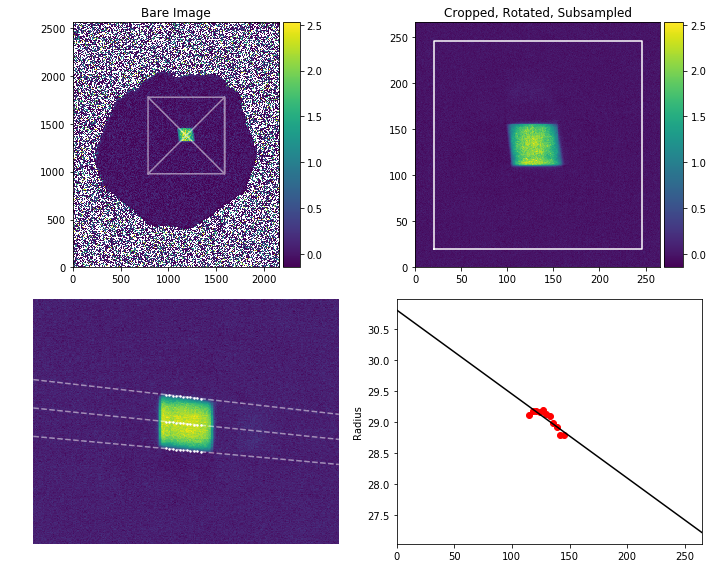

In [446]:
# Verify Settings 

# Apply to all Images 
for n,r in df_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_all.shape[0])):
    r = df_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    plt.show()

if df_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_all.shape[0]-1))

In [447]:
# Start Saving Folder 
savefig = ipywidgets.Checkbox(value=True, description='Save Figs')
display(savefig)
folder_name = df_all.iloc[0].name[0:17] + 'BoxShaking'
suffix = os.path.join(folder_name, '')
os.makedirs(folder_name, exist_ok=True)
suffix_samples = os.path.join(folder_name, 'Samples','')
os.makedirs(os.path.join(folder_name, 'Samples'), exist_ok=True)
suffix

'07-16-2018_17_08_BoxShaking\\'

In [448]:
# Define backgrounds 
background_parameter = 'ShakingCycles'
background_value = 0
df_all['bg'] = df_all[background_parameter] == background_value


Total Images 29 ==> Good 29, Bad 0


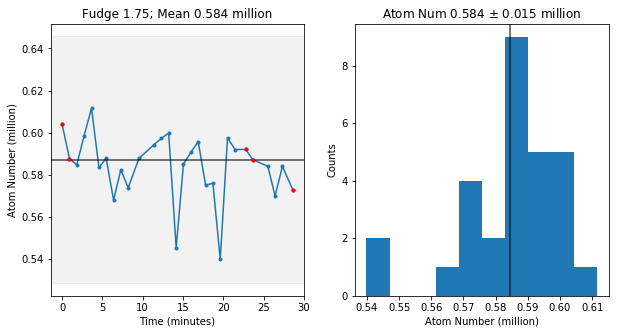

In [449]:
# Atom Number Filter 
df_all['total_atoms'] = [im.total_atoms for im in tqdm(df_all.image)]
ax = tp.atom_num_filter(df=df_all, keep=0.10, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
ax[0].plot(df_all.loc[df_all['bg'], 'time'], df_all.loc[df_all['bg'], 'total_atoms']/1e6, 'r.')
if savefig.value: plt.savefig(suffix + 'AtomNumbersScatter.pdf')
df = df_all[df_all.use]

[  60.   70.   80.   90.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.]


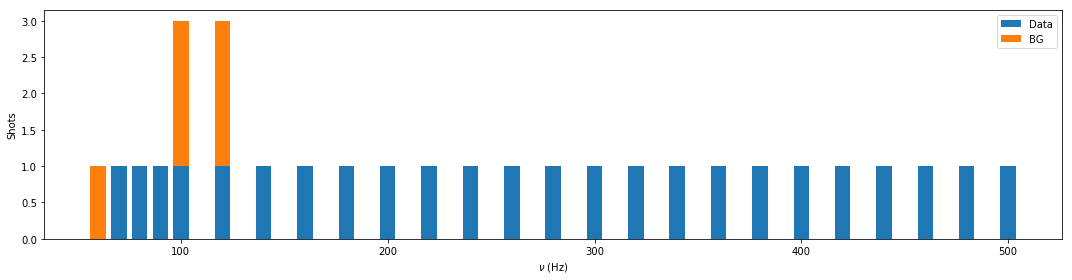

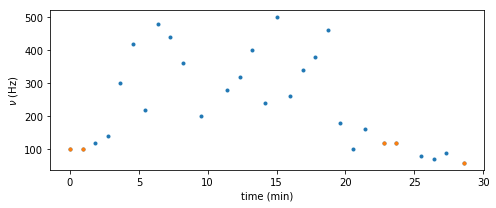

In [450]:
# Dataset Explorer 
def dataset_counter(df, bg_param='bg', bg_value=True, x='x', plot=False, ax=None, xlabel='x'):
    '''
    count the occurances of various x data points and bg points 
    '''
    # Count number of images 
    unique_x = np.unique(df[x])
    data_counts = np.array([np.sum(df[x][df[bg_param] != bg_value] == xi) for xi in unique_x])
    bg_counts = np.array([np.sum(df[x][df[bg_param] == bg_value] == xi) for xi in unique_x])
    dataset_counter = [unique_x, data_counts, bg_counts]
    
    # Plot
    if plot: 
        ax = plt.subplots(figsize=[15,4])[1] if (ax is None) else ax
        width = np.min(np.diff(dataset_counter[0]))*0.75 if (len(dataset_counter[0]) > 1) else 1
        ax.bar(dataset_counter[0], dataset_counter[1], width, label='Data')
        ax.bar(dataset_counter[0], dataset_counter[2], width, bottom=dataset_counter[1], label='BG')
        ax.legend()
        ax.set(xlabel = xlabel, ylabel='Shots')
        plt.tight_layout()
    
    return dataset_counter, ax

ds_counter, ax = dataset_counter(df=df, plot=True, xlabel=x_var_label)
if savefig.value: ax.figure.savefig(suffix + 'DatasetCounter_vsX.pdf')
print(np.unique(df.x.values))
plt.figure(figsize = [7, 3])
plt.plot(df.time, df.x, '.')
bgi = df[background_parameter] == background_value
plt.plot(df.time[bgi], df.x[bgi], '.')
plt.xlabel('time (min)')
plt.ylabel(x_var_label)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'DatasetCounter_vsTime.pdf')

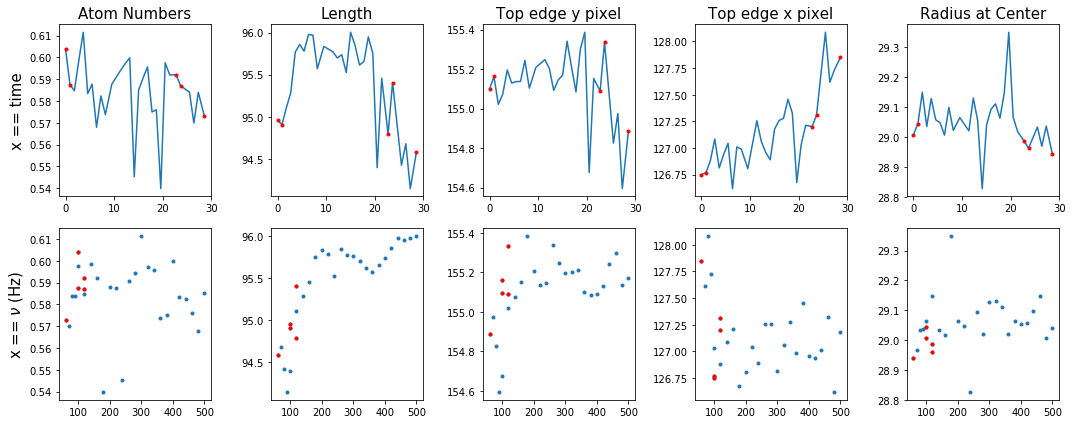

In [451]:
# Box Length and Center 
df['nz_raw'] = [im.nz for im in tqdm(df.image)]
df['pz_raw'] = [tp.Curve(x = nz.x, y = np.arange(len(nz.x))) for nz in df['nz_raw']]
df['xsec_raw'] = [im.xsec for im in df.image]
guess_ = [-45e-6, 45e-6, 5e-6, 5e-6]
df['box_fit'] = [tp.curve_fit(tp.erf_box, guess_ + [nz.maxy, nz.maxy/1e3], *nz.data, ) for nz in df['nz_raw']]
df['length'] = [f[1] - f[0] for f in df['box_fit']]
df['top_ypixel'] = [r['pz_raw'](r['box_fit'].fv[1]) for n,r in df.iterrows()]
df['top_xpixel'] = [r['xsec_raw'].get_center(r['top_ypixel']) for n,r in df.iterrows()]
df['bottom_ypixel'] = [r['pz_raw'](r['box_fit'].fv[0]) for n,r in df.iterrows()]
df['bottom_xpixel'] = [r['xsec_raw'].get_center(r['bottom_ypixel']) for n,r in df.iterrows()]
df['center_ypixel'] = [r['pz_raw']((r['box_fit'].fv[0] + r['box_fit'].fv[1])/2) for n,r in df.iterrows()]
df['center_xpixel'] = [r['xsec_raw'].get_center(r['center_ypixel']) for n,r in df.iterrows()]
df['center_radius'] = [r['xsec_raw'].get_radius(r['center_ypixel']) for n,r in df.iterrows()]
df['nz_fixed'] = [tp.Curve(x = r.nz_raw.x, y = r.nz_raw.y - r.box_fit(amp=0), xscale=1e-6, yscale=1e18) for n,r in df.iterrows()]
# df['nz_integral'] = [np.trapz(c.y, c.x) for c in df['nz_fixed']] # Integrate over all
df['nz_integral'] = [np.trapz(c.trim(xlim=[-60e-6, 60e-6]).y, c.trim(xlim=[-60e-6, 60e-6]).x) for c in df['nz_fixed']] # Integrate over [-60, 60]

# Plot test 
ax = plt.subplots(ncols=5, nrows=2, figsize=[15, 6])[1].flatten()
bgi = df[background_parameter] == background_value

ax[0].plot(df['time'], df['total_atoms']/1e6)
ax[1].plot(df['time'], df['length']*1e6)
ax[2].plot(df['time'], df['top_ypixel'])
ax[3].plot(df['time'], df['top_xpixel'])
ax[4].plot(df['time'], df['center_radius'])

ax[0].plot(df.loc[bgi, 'time'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[1].plot(df.loc[bgi, 'time'], df.loc[bgi, 'length']*1e6, 'r.')
ax[2].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[3].plot(df.loc[bgi, 'time'], df.loc[bgi, 'top_xpixel'], 'r.')
ax[4].plot(df.loc[bgi, 'time'], df.loc[bgi, 'center_radius'], 'r.')

ax[5].plot(df['x'], df['total_atoms']/1e6, '.')
ax[6].plot(df['x'], df['length']*1e6, '.')
ax[7].plot(df['x'], df['top_ypixel'], '.')
ax[8].plot(df['x'], df['top_xpixel'], '.')
ax[9].plot(df['x'], df['center_radius'], '.')

ax[5].plot(df.loc[bgi, 'x'], df.loc[bgi, 'total_atoms']/1e6, 'r.')
ax[6].plot(df.loc[bgi, 'x'], df.loc[bgi, 'length']*1e6, 'r.')
ax[7].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_ypixel'], 'r.')
ax[8].plot(df.loc[bgi, 'x'], df.loc[bgi, 'top_xpixel'], 'r.')
ax[9].plot(df.loc[bgi, 'x'], df.loc[bgi, 'center_radius'], 'r.')

ax[0].set_title('Atom Numbers', fontsize=15)
ax[1].set_title('Length', fontsize=15)
ax[2].set_title('Top edge y pixel', fontsize=15)
ax[3].set_title('Top edge x pixel', fontsize=15)
ax[4].set_title('Radius at Center', fontsize=15)
ax[0].set_ylabel(r'x == time', fontsize=15)
ax[5].set_ylabel(r'x == {}'.format(x_var_label), fontsize=15)

plt.tight_layout()

if savefig.value: plt.savefig(suffix + 'DatasetQuality.pdf')

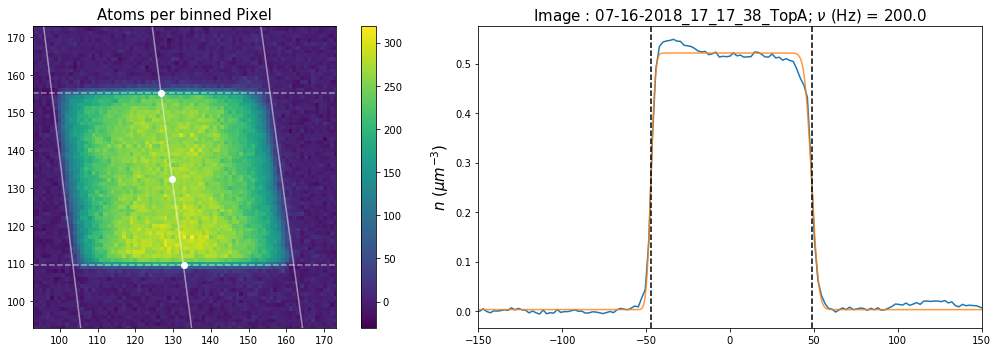

In [452]:
# Test box fit 
size = 80
test = 0
def temp(test=np.random.randint(df.shape[0])):
    r = df.iloc[test]
    roi = tp.get_roi(r.image.app, width=size, height=size)
    fig, ax = plt.subplots(ncols=2, figsize=[15, 5])
    plt.sca(ax[0])
    plt.imshow(r.image.app)
    plt.colorbar()
    plt.title('Atoms per binned Pixel', fontsize=15)
    plt.plot(r.xsec_raw.get_center(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_left(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.plot(r.xsec_raw.get_right(r.xsec_raw.z), r.xsec_raw.z, 'w-', alpha=0.5)
    plt.axhline(r.top_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.axhline(r.bottom_ypixel, c='w', alpha=0.5, linestyle='--')
    plt.plot([r.top_xpixel, r.bottom_xpixel, r.center_xpixel], [r.top_ypixel, r.bottom_ypixel, r.center_ypixel], 'ow')
    ax[0].set(xlim=[roi[1].start, roi[1].stop], ylim=[roi[0].start, roi[0].stop])
    ax[1].plot(*r.nz_raw.plotdata)
    ax[1].plot(r.box_fit.xp * 1e6, r.box_fit(r.box_fit.xp) / 1e18, alpha=0.8)
    ax[1].axvline(r.box_fit[0]*1e6, c='k', linestyle='--',)
    ax[1].axvline(r.box_fit[1]*1e6, c='k', linestyle='--',)
    ax[1].set(xlim=[-150, 150])
    image_kind = 'BG' if r[background_parameter] == background_value else 'Image'
    ax[1].set_title('{} : {}; {} = {}'.format(image_kind, r.name, x_var_label, r.x), fontsize=15)
    ax[1].set_ylabel(r'$n$ $(\mu m^{-3})$', fontsize=15)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'BoxFitsSamples_{}_{}.pdf'.format(r.x, r.name))
    plt.show()
if df.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df.shape[0]-1))

In [453]:
# IMPORTANT SETTINGS 
shared_background = True 
proper_center = 'center' # top or center or bottom or none 
zero_z = 'center' # where to put the zero for z top, bottom, center 

In [454]:
# Begin df_data and allocate images 
threshold_image_num = 1

# use dataset with enough images only
if shared_background == False:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and (ds_counter[2][i] >= threshold_image_num)]
elif shared_background == True:
    xlist = [x for i, x in enumerate(ds_counter[0]) 
             if (ds_counter[1][i] >= threshold_image_num) and ds_counter[2].sum() >= threshold_image_num]
df_data = pd.DataFrame(index = xlist)

# Compute things 
df_data['data_ind'] = [(df.x == x) & (~ df['bg']) for x in df_data.index.values]
df_data['# data'] = [np.sum(t) for t in df_data['data_ind']]
if shared_background:
    df_data['bg_ind'] = [df['bg'] for x in df_data.index.values]
else:
    df_data['bg_ind'] = [df['bg'] & (df.x == x) for x in df_data.index.values]
df_data['# bg'] = [np.sum(t) for t in df_data['bg_ind']]
df_data['length'] = [np.mean(df.loc[ind,'length']) for ind in df_data['bg_ind']]
df_data['freq'] = [df.loc[ind,'BoxShakeFreq'].iloc[0] for ind in df_data['data_ind']]
df_data['cycles'] = [df.loc[ind,'ShakingCycles'].iloc[0] for ind in df_data['data_ind']]

# Start dict_data 
dict_data = {}

In [455]:
# Calculate proper n(z) for each item in df 

# calculate proper length and density rescaling factor 
df['proper_length'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'length']) 
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'length']) 
                       for n,r in df.iterrows()]
df['proper_nrescale'] = [np.mean(df.loc[df_data.loc[r.x, 'bg_ind'], 'nz_integral']) / r['nz_integral']
                       if (r.x in xlist) else np.mean(df.loc[df.bg, 'nz_integral']) / r['nz_integral']
                       for n,r in df.iterrows()]
        
# where to put zero of z 
if zero_z == 'bottom': df['subtract_z'] = - df['proper_length'] / 2
elif zero_z == 'top': df['subtract_z'] = df['proper_length'] / 2 
else: df['subtract_z'] = 0

# calculate nz using proper center and zero of z and proper density rescaling 
default_z = (np.arange(df.iloc[0].nz_raw.x.size) - np.mean(df.loc[df.bg, 'center_ypixel'])) * df.iloc[0].image.pixel_binned
if proper_center == 'top':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[1] - r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'bottom':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.proper_length/2) - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
elif proper_center == 'center':
    df['nz'] = [tp.Curve(r.nz_fixed.x - (r.box_fit[0] + r.box_fit[1])/2 - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]
else:
    df['nz'] = [tp.Curve(default_z - r.subtract_z, 
                         r.nz_fixed.y * r.proper_nrescale) for n,r in df.iterrows()]



In [456]:
# Calculate dn and dn/n 
def concat_curves(cs):
    xs = np.concatenate([c.x for c in cs])
    ys = np.concatenate([c.y for c in cs])
    c_concat = tp.Curve(xs, ys).sortbyx()
    c = c_concat.binbyx(step = np.diff(cs[0].x)[0])
    return (c_concat, c)

df_data['nz data all'] = [list(df.loc[r.data_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz bg all'] = [list(df.loc[r.bg_ind, 'nz']) for x,r in df_data.iterrows()]
df_data['nz data'] = [concat_curves(cs)[1] for cs in df_data['nz data all']]
df_data['nz bg'] = [concat_curves(cs)[1] for cs in df_data['nz bg all']]
df_data['box fit bg'] = [tp.curve_fit(tp.erf_box, [-45e-6, 45e-6, 5e-6, 5e-6, c.maxy, c.maxy/1e3], *c.data) for c in df_data['nz bg']]

df_data['dn']   = [tp.Curve(y = r['nz data'](r['nz bg'].x) - r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=r['box fit bg']['amp']*1e-2)
                   for x,r in df_data.iterrows()]
df_data['dn/n'] = [tp.Curve(y = (r['nz data'](r['nz bg'].x) - r['nz bg'].y) / r['nz bg'].y, 
                   x = r['nz bg'].x, xscale = 1e-6, yscale=1e-2)
                   for x,r in df_data.iterrows()]

In [457]:
# Calculate 2d dn == centered at the center of the image 
width = 180e-6 
pixel = df.iloc[0].image.pixel_binned 
size_pixels = int(width / pixel / 2)
x = np.arange(-size_pixels, size_pixels, 1)
y = x.copy()

# Compute shifted app 
def temp(r):
    y_ = (r['nz'].x + r['subtract_z']) / pixel
    x_ = np.arange(r.image.app.shape[1]) - r['center_xpixel']
    interp = scipy.interpolate.interp2d(x_, y_, r.image.app * r.proper_nrescale, kind='linear')
    return interp(x, y)
df['app_shifted'] = [temp(r) for n, r in df.iterrows()]

# Compute 2d dn
df_data['2d dn'] = [np.mean(df.loc[r.data_ind, 'app_shifted']) - np.mean(df.loc[r.bg_ind, 'app_shifted']) 
                    for x,r in df_data.iterrows()]


In [458]:
# Calculate Box Characteristics 
box_char = pd.DataFrame()
box_char['fudge'] = [df.image.iloc[0].fudge]
box_char['length (um)'] = np.mean(df.loc[df.bg, 'length']) * 1e6
box_char['length (um) error'] = np.std(df.loc[df.bg, 'length']) * 1e6
box_char['radius (um)'] = np.mean(df.loc[df.bg, 'center_radius']) * df.image.iloc[0].pixel_binned * 1e6
box_char['radius (um) error'] = np.std(df.loc[df.bg, 'center_radius']) * df.image.iloc[0].pixel_binned * 1e6
box_char['atom num (million)'] = np.mean(df.loc[df.bg, 'total_atoms']) / 1e6
box_char['atom num (million) error'] = np.std(df.loc[df.bg, 'total_atoms']) / 1e6
box_char['n (um^-3)'] = box_char['atom num (million)'] * 1e6 / (np.pi * box_char['radius (um)']**2 * box_char['length (um)'])
box_char['n (um^-3) error'] = box_char['atom num (million) error'] * 1e6 / (np.pi * box_char['radius (um)']**2 * box_char['length (um)'])
box_char['EF (kHz)'] = cst.n2EFHz(box_char['n (um^-3)'] * 1e18) / 1e3
box_char['EF (kHz) error'] = 2/3 * cst.n2EFHz(box_char['n (um^-3)'] * 1e18) / 1e3 * box_char['n (um^-3) error'] / box_char['n (um^-3)']
if savefig.value: box_char.to_excel(suffix + 'box_characteristics.xlsx')
box_char

,fudge,length (um),length (um) error,radius (um),radius (um) error,atom num (million),atom num (million) error,n (um^-3),n (um^-3) error,EF (kHz),EF (kHz) error
0,1.75,94.929869,0.27118,60.87673,0.074801,0.588709,0.009986,0.532655,0.009035,8.387589,0.094851


## Movie

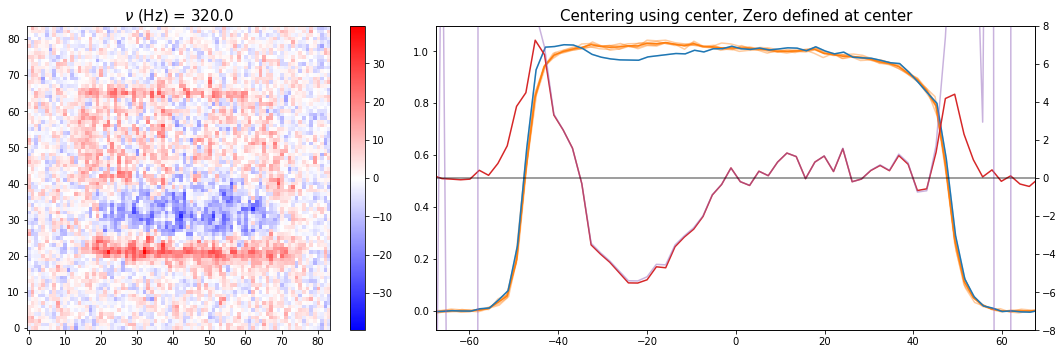

In [459]:
# Plot Samples 
Lum = np.mean(df.loc[df.bg, 'length']) * 1e6
plot_zlim = np.array([0 - 20, Lum + 20])
if zero_z == 'center': plot_zlim -= Lum/2 
elif zero_z == 'top': plot_zlim -= Lum
def temp(test=np.random.randint(0, df_data.shape[0])): 
    r = df_data.iloc[test]
    fig = plt.figure(figsize=[15, 5])
    # Plot Image
    plt.subplot2grid((1,5),(0,0), colspan = 2)
    app = np.nan_to_num(r['2d dn'])
    plt.imshow(app, origin=0, clim=[-np.max(np.abs(app)), np.max(np.abs(app))], cmap='bwr')
    plt.title("{} = {}".format(x_var_label, r.name), fontsize=15)
    plt.colorbar()
    # Plot n(z) 
    ax = plt.subplot2grid((1,5),(0,2), colspan = 3)
    for n in r['nz bg all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C1-', alpha=2/len(r['nz bg all']))
    plt.plot(r['nz bg'].x*1e6, r['nz bg'].y / r['box fit bg']['amp'], 'C1-')
    for n in r['nz data all']:
        plt.plot(n.x*1e6, n.y/r['box fit bg']['amp'], 'C0-', alpha=0.2)
    plt.plot(r['nz data'].x*1e6, r['nz data'].y / r['box fit bg']['amp'], 'C0-')
    plt.xlim(plot_zlim)
    plt.title('Centering using {}, Zero defined at {}'.format(proper_center, zero_z), fontsize=15)
    ax = plt.twinx(ax)
    ax.plot(*r['dn'].plotdata, 'C3')
    ax.plot(*r['dn/n'].plotdata, 'C4', alpha=0.5)
    ax.axhline(0, c='k', alpha=0.5)
    lim = np.nanmax(np.abs(r['dn'].plotdata[1]))* 1.1
    ax.set(ylim = [-lim, lim], xlim=plot_zlim)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'InsituSoundWaves_{}.pdf'.format(r.name))
    plt.show()
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

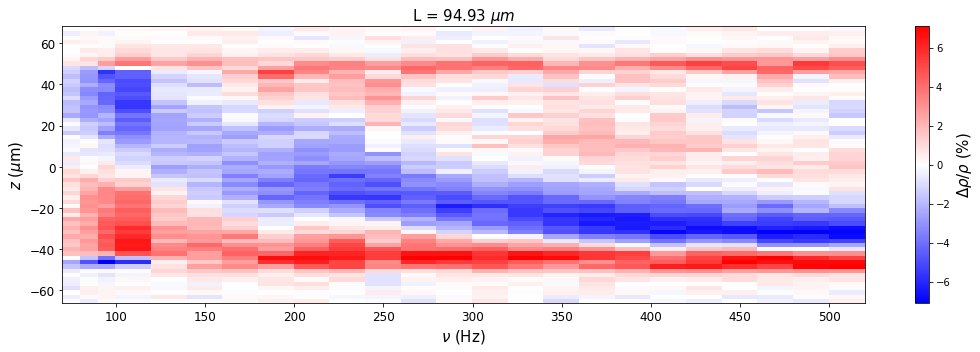

In [460]:
# Movies 
movie = np.array([(r.dn.trim(plot_zlim * 1e-6).y) / r['box fit bg']['amp'] * 100 for x,r in df_data.iterrows()]).T
movie = [df_data.index.values, df_data.iloc[0]['dn'].trim(plot_zlim * 1e-6).x * 1e6, movie]
if savefig.value: pd.DataFrame(movie[2], index=movie[1], columns=movie[0]).to_excel(suffix + '2d_movie.xlsx')

# Plots 
clim_movie = np.max(np.abs(movie[2])) * 0.9
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(movie), cmap='bwr', vmin=-clim_movie, vmax=clim_movie, linewidth=0)
plt.ylabel(r'$z$ ($\mu$m)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix + 'SonogramMovie_bwr.pdf')

In [461]:
# Specialized Plots == 3 column - 2d rho_0, rho, delta_rho ; 2 column - 1d rho_0, rho, delta_rho  
# r = df_data.loc[450]
# a1 = df[r['bg_ind']].iloc[0].image.app
# a2 = df[r['data_ind']].iloc[0].image.app
# a3 = r['2d dn']
# roi = tp.get_roi(a1, width=a3.shape[1], height=a3.shape[0])

# fig, ax = plt.subplots(ncols=3, figsize=[12,4])
# for a in ax: a.set_axis_off()
# plt.sca(ax[2])
# plt.imshow(a3, origin=0, cmap='bwr')
# plt.title(r'$\Delta \rho = \rho - \rho_0$', fontsize=15)

# plt.sca(ax[0])
# plt.imshow(a1[roi], origin=0, cmap='viridis')
# plt.title(r'$\rho_{0}$ : Background Density', fontsize=15)

# plt.sca(ax[1])
# plt.imshow(a2[roi], origin=0, cmap='viridis')
# plt.title(r'$\rho$ : After Shaking', fontsize=15)

# plt.tight_layout()
# plt.savefig('Sample_SoundDemo_v1_{}.pdf'.format(r.name))
# plt.show()

# fig, ax = plt.subplots(ncols=2, figsize=[12,4])
# for a in ax: 
#     a.set(xlim=plot_zlim)
#     a.set_xlabel(r'z ($\mu m$)', fontsize=15)
# plt.sca(ax[0])
# plt.plot(r['nz bg'].x * 1e6, r['nz bg'].y / 1e18)
# plt.plot(r['nz data'].x * 1e6, r['nz data'].y / 1e18)
# plt.ylabel(r'$\rho$ ($\mu m^{-3}$)', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.sca(ax[1])
# plt.plot(*r['dn'].plotdata)
# plt.ylabel(r'$\Delta \rho / \rho_0$ (%)', fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.tight_layout()
# plt.savefig('Sample_SoundDemo_v2_{}.pdf'.format(r.name))

In [462]:
# # Specialized Plots == Bunch of 2d delta_rho in a single row & Bunch of 1d delta_rho in column 

# freqs = [78, 100, 150, 190, 300, 400,] 
# freqs = [500, 600, 750, 850, 1100]
# fig, ax = plt.subplots(ncols=len(freqs), figsize=[2.5 * len(freqs), 2.5])
# for f,a in zip(freqs,ax): 
#     a.set_axis_off()
#     plt.sca(a)
#     plt.imshow(df_data.loc[f,'2d dn'], origin=0, cmap='bwr', clim=[-30, 30])
#     a.set_title(r'{} Hz'.format(f))
# plt.subplots_adjust(wspace=0)
# # plt.savefig('Sample_SoundDemo_v3.pdf')
# plt.show()


# freqs = [500, 750, 1100][::-1]
# shift = np.arange(len(freqs))[::-1]
# fig, ax = plt.subplots(figsize=[5,6])
# for f,s in zip(freqs[::-1], shift):
#     ax.plot(df_data.loc[f, 'dn'].plotdata[0], df_data.loc[f, 'dn'].plotdata[1] + s*10, 'C{}'.format(s), label='{} Hz'.format(f))
#     ax.axhline(s*10, color='C{}'.format(s), alpha=0.5, linestyle='--')
# ax.set(xlim=[0,100], ylim=[None, 29])
# plt.xlabel(r'z ($\mu$m)', fontsize=15)
# plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)
# plt.legend(fontsize=13)
# # plt.savefig('Sample_SoundDemo_v4.pdf')


In [463]:
# # MISC : Plot for Sound Paper Fig1 
# ind = 8

# # Extract average data 
# r = df_data.iloc[ind]
# # print(r)
# sound_2d = []
# sound_2d.append( np.mean(df.loc[r.bg_ind,   'app_shifted']) )
# sound_2d.append( np.mean(df.loc[r.data_ind, 'app_shifted']) )
# sound_2d.append( sound_2d[1] - sound_2d[0] )

# # Store images as excel for Fig1 maker program 
# fnames = ['Sample_Sound_0727_600Hz_BG.xlsx', 
#           'Sample_Sound_0727_600Hz_Data.xlsx', 
#           'Sample_Sound_0727_600Hz_Delta.xlsx', 
#           'Sample_Sound_0727_600Hz_1D.xlsx']
# for i,d in enumerate(sound_2d):
#     pd.DataFrame(d).to_excel(fnames[i])

# # Crop data 
# roi = tp.get_roi(sound_2d[0], width=66, height=57, center=[1,-1])
# sound_2d = [s[roi].T for s in sound_2d]

# # Plot all 
# fig, ax = plt.subplots(figsize=[14*0.7, 14/4*0.7 ], ncols=4)
# ax[0].pcolormesh(sound_2d[0], linewidth=0,rasterized=True)
# ax[1].pcolormesh(sound_2d[1], linewidth=0,rasterized=True)
# vmax = np.max(np.abs(sound_2d[2])) * 0.8
# ax[2].pcolormesh(sound_2d[2], linewidth=0, cmap='bwr',rasterized=True, vmin=-vmax, vmax=vmax)
# ax[3].plot(*r.dn.plotdata)
# ax[3].set(xlim=[-10, 100], ylim=[-7, 7])
# plt.tight_layout(pad=0.2)


# Fourier Components 

In [464]:
# Used Functions 

def discrete_modes_v1(x, L=1, phase=0, a0=0, grad=0, a1=0, a2=0, 
                      a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0, a11=0, a12=0, 
                      a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (cos), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.cos(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.cos(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.cos(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.cos(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.cos(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.cos(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.cos(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.cos(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.cos(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v2(x, L=1, a0=0, grad=0, a1=0, p1=0, 
                   a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (cos): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.cos(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.cos(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.cos(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.cos(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.cos(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.cos(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.cos(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.cos(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.cos(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.cos(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y

def discrete_modes_v3(x, L=1, phase=0, a0=0, grad=0, 
                      a1=0, a2=0, a3=0, a4=0, a5=0, a6=0, a7=0, a8=0, a9=0, a10=0,
                      a11=0, a12=0, a13=0, a14=0, a15=0, a16=0, a17=0, a18=0, a19=0, a20=0,):
    '''Common L and phase (sin, cos, ...), separate amplitudes: upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - phase)
    y += a2 * np.cos(2 * np.pi/L * x - phase)
    y += a3 * np.sin(3 * np.pi/L * x - phase)
    y += a4 * np.cos(4 * np.pi/L * x - phase)
    y += a5 * np.sin(5 * np.pi/L * x - phase)
    y += a6 * np.cos(6 * np.pi/L * x - phase)
    y += a7 * np.sin(7 * np.pi/L * x - phase)
    y += a8 * np.cos(8 * np.pi/L * x - phase)
    y += a9 * np.sin(9 * np.pi/L * x - phase)
    y += a10 * np.cos(10 * np.pi/L * x - phase)
    y += a11 * np.sin(11 * np.pi/L * x - phase)
    y += a12 * np.cos(12 * np.pi/L * x - phase)
    y += a13 * np.sin(13 * np.pi/L * x - phase)
    y += a14 * np.cos(14 * np.pi/L * x - phase)
    y += a15 * np.sin(15 * np.pi/L * x - phase)
    y += a16 * np.cos(16 * np.pi/L * x - phase)
    y += a17 * np.sin(17 * np.pi/L * x - phase)
    y += a18 * np.cos(18 * np.pi/L * x - phase)
    y += a19 * np.sin(19 * np.pi/L * x - phase)
    y += a20 * np.cos(20 * np.pi/L * x - phase)
    return y

def discrete_modes_v4(x, L=1, a0=0, grad=0, 
                   a1=0, p1=0, a2=0, p2=0, a3=0, p3=0, a4=0, p4=0, a5=0, p5=0, 
                   a6=0, p6=0, a7=0, p7=0, a8=0, p8=0, a9=0, p9=0, a10=0, p10=0, 
                   a11=0, p11=0, a12=0, p12=0, a13=0, p13=0, a14=0, p14=0, a15=0, 
                   p15=0, a16=0, p16=0, a17=0, p17=0, a18=0, p18=0, a19=0, p19=0, a20=0, p20=0):
    '''Common L, separate amplitudes and phases (sin, cos, ...): upto 20 modes'''
    y = a0 + grad * x 
    y += a1 * np.sin(1 * np.pi/L * x - p1)
    y += a2 * np.cos(2 * np.pi/L * x - p2)
    y += a3 * np.sin(3 * np.pi/L * x - p3)
    y += a4 * np.cos(4 * np.pi/L * x - p4)
    y += a5 * np.sin(5 * np.pi/L * x - p5)
    y += a6 * np.cos(6 * np.pi/L * x - p6)
    y += a7 * np.sin(7 * np.pi/L * x - p7)
    y += a8 * np.cos(8 * np.pi/L * x - p8)
    y += a9 * np.sin(9 * np.pi/L * x - p9)
    y += a10 * np.cos(10 * np.pi/L * x - p10)
    y += a11 * np.sin(11 * np.pi/L * x - p11)
    y += a12 * np.cos(12 * np.pi/L * x - p12)
    y += a13 * np.sin(13 * np.pi/L * x - p13)
    y += a14 * np.cos(14 * np.pi/L * x - p14)
    y += a15 * np.sin(15 * np.pi/L * x - p15)
    y += a16 * np.cos(16 * np.pi/L * x - p16)
    y += a17 * np.sin(17 * np.pi/L * x - p17)
    y += a18 * np.cos(18 * np.pi/L * x - p18)
    y += a19 * np.sin(19 * np.pi/L * x - p19)
    y += a20 * np.cos(20 * np.pi/L * x - p20)
    return y



## fourier transform with cropped L

In [465]:
# Start a figure folder 
display(savefig)
suffix_ft = os.path.join(folder_name, 'FT Centered Cropped','')
os.makedirs(os.path.join(suffix_ft), exist_ok=True)
suffix_ft

'07-16-2018_17_08_BoxShaking\\FT Centered Cropped\\'

In [466]:
# Prepare for FT 
length_mult = 1.07
shift = 0
if zero_z == 'center': shift -= Lum*length_mult/2
elif zero_z == 'top': shift -= Lum*length_mult
fit_zlim = (np.array([0 + 0, Lum*length_mult - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum*length_mult, 100) + shift

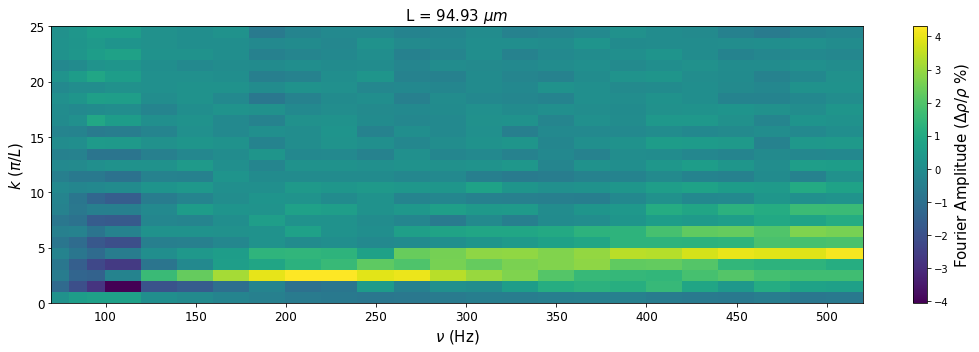

In [467]:
# Compute FT 
kscale = np.pi/(Lum * length_mult)
k = np.arange(0, 25 * kscale, 1 * kscale)
ft = np.array([tp.fourier_transform(*c.trim(xlim=fit_zlim).plotdata, k)[1] for c in df_data['dn/n']]).T
ft *= 2 * kscale / np.pi
ft_real = [df_data.index.values, k/kscale, np.real(ft)]
ft_imag = [df_data.index.values, k/kscale, np.imag(ft)]
ft_abs = [df_data.index.values, k/kscale, np.abs(ft)]

sign = np.array([-1,-1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,])
sign = np.meshgrid(np.ones(ft.shape[1]), sign[:ft.shape[0]])[1]
mult = np.meshgrid(np.ones(ft.shape[1]), np.arange(ft.shape[0]))[1]
# ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]
ft = [df_data.index.values, k/kscale, ft_imag[2] * (mult%2) * sign + ft_real[2] * ((mult+1)%2) * sign]
if savefig.value: pd.DataFrame(ft[2], index=ft[1], columns=ft[0]).to_excel(suffix_ft + 'fourier_transform.xlsx')
    
# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.85
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'FourierAmpsMovie_viridis.pdf')

## Lorentzian Fits

In [2296]:
# Lorentzian Fit Info 
mode_num = np.array([1,])
ref_freq_guess = np.mean(ft[0])
ref_freq_guess = 15
gamma_guess = mode_num * 10
fit_widths = {1:30, 2:120, 3:170, 4:250, 5:300, 6:400, 7:300, 8:400, 9:500, 10:500}
fit_lims = {i:[ref_freq_guess*i - fit_widths.get(i,1000)/2, 
               ref_freq_guess*i + fit_widths.get(i,1000)/2] for i in range(1,10)}
# fit_lims = {}

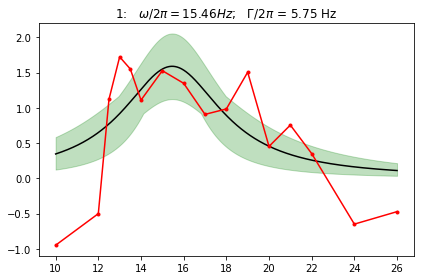

In [2297]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1,)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(mode_num[i], [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

if len(mode_num) == 1:
    ax = plt.subplots()[1]
    i, m = 0, mode_fits[0]
    m.plot_fiterrors(ax=ax)
    ax.set(title=r'{}:   $\omega/2\pi = {:.2f} Hz$;   $\Gamma/2\pi$ = {:.2f} Hz'.format(mode_num[i], m['x0'], abs(m['gamma'])))
else:
    ax = plt.subplots(ncols=4, nrows=3, figsize=[15,9])[1].flatten()
    for i,m in enumerate(mode_fits):
        m.plot_fiterrors(ax=ax[i])
        ax[i].set(title=r'{} :: {:.1f} Hz;   $\Gamma/2\pi$={:.2f} Hz'.format(mode_num[i], m['x0'], abs(m['gamma'])))

plt.tight_layout()
if savefig.value: plt.savefig(suffix_ft + 'LorentzianFits.pdf')

In [2089]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['k (1/m) error'] = 0
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['c (m/s)'] = modes['w (1/s)'] / modes['k (1/m)']
modes['c (m/s) error'] = modes['w (1/s) error'] / modes['k (1/m)']
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['D (hbar/m)'] = modes['gamma (1/s)'] / modes['k (1/m)']**2 / (cst.hbar/cst.mass)
modes['D (hbar/m) error'] = modes['gamma (1/s) error'] / modes['k (1/m)']**2 / (cst.hbar/cst.mass)
modes['FT amplitude (%)'] = [cf['amp'] for cf in mode_fits]
modes['FT amplitude (%) error'] = [cf.fe['amp'] for cf in mode_fits]
modes = modes.set_index('mode num', drop=False)

if savefig.value: modes.to_excel(suffix_ft + 'modes_results.xlsx')
modes.iloc[0]

mode num                      1.000000
k (1/m)                   32819.978767
k (1/m) error                 0.000000
f (Hz)                       15.351279
f (Hz) error                  0.240831
f0 (Hz)                      15.351279
f0 (Hz) error                 0.240831
w (1/s)                      96.454933
w (1/s) error                 1.513184
c (m/s)                       0.002939
c (m/s) error                 0.000046
gamma (Hz)                    6.069447
gamma (Hz) error              0.775705
gamma (1/s)                  38.135460
gamma (1/s) error             4.873896
D (hbar/m)                    3.353280
D (hbar/m) error              0.428565
FT amplitude (%)              2.924110
FT amplitude (%) error        0.229973
Name: 1, dtype: float64

In [2090]:
# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
# xp = np.linspace(0, modes['mode num'].max() + 0.4)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel('Mode Number', fontsize=15)
# plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
# plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'FundamentalFrequency_v1.pdf')

# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
# dict_data['speed fit'] = cf
# xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
# plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
# plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v1.pdf')

# # Plot Freq vs Mode Num 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, fmt='bo')
# cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)']*1e-3, modes['w (1/s) error']*1e-3, info=False, plot=False)
# xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
# plt.ylabel(r'$\omega$ (1/ms)', fontsize=15)
# plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0], cf.fe[0]), fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'Dispersion Relation_v2.pdf')

# # Plot Gamma vs Freq 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma$ is FWHM', fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v1.pdf')

# # Plot Gamma vs Omega with Linear Fit
# modes_ = modes.iloc[2:]
# cf = tp.curve_fit(lambda x, a1=0, a0=0: a0 + a1 * x, [1,0], modes_['f (Hz)'], modes_['gamma (Hz)'], modes_['gamma (Hz) error'], info=True)
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
# xp = np.linspace(0, cf.x.max()*1.05, 100)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma = {:.2f} \pm {:.2f} \: \omega - {:.2f}$'.format(cf[0], cf.fe[0], -cf[1]), fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v2.pdf')
    
# # Plot Gamma vs Omega with Quadratic Fit 
# cf = tp.curve_fit(lambda x, a2=0: a2*x**2, [1], modes['w (1/s)'], modes['gamma (1/s)'], modes['gamma (1/s) error'], info=True)
# speed = dict_data['speed fit'][0] * 1e-6
# eta_rho = [3/4 * cf[0] * speed**2 * cst.mass / cst.hbar, 3/4 * cf.fe[0] * speed**2 * cst.mass / cst.hbar]
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['w (1/s)'], modes['gamma (1/s)'], xerr=modes['w (1/s) error'], yerr=modes['gamma (1/s) error'], fmt='bo')
# xp = np.linspace(0, cf.x.max()*1.05, 100)
# plt.plot(xp, cf(xp), 'k-')
# plt.xlabel(r'$\omega$ (1/s)', fontsize=15)
# plt.ylabel(r'$\Gamma$ (1/s)', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar / m$'.format(*eta_rho), fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'GammaVsOmega_v3.pdf')

# # Plot Q vs Freq 
# fig, ax = plt.subplots(figsize=[6,6])
# plt.errorbar(modes['f (Hz)'], modes['f (Hz)']/modes['gamma (Hz)'], xerr=modes['f (Hz) error'], 
#              yerr=np.sqrt((modes['f (Hz) error']/modes['gamma (Hz)'])**2 + (modes['gamma (Hz) error'] * modes['f (Hz)']/modes['gamma (Hz)']**2)**2), fmt='bo')
# plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
# plt.ylabel(r'Q = $\omega / \Gamma $', fontsize=15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.title(r'$\Gamma$ is FWHM', fontsize=15)
# plt.xlim([0, None])
# plt.ylim([0, None])
# plt.tight_layout()
# if savefig.value: plt.savefig(suffix_ft + 'QVsFreq_v1.pdf')

In [2091]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

## Fitting Peaks for Wavelength

In [226]:
# Determine where to fit sin 
m = 2
freq_ = modes.loc[m, 'f (Hz)']
gamma_ = modes.loc[m, 'gamma (Hz)']
wl_ = twopi / modes.loc[m, 'k (1/m)'] * 1e6
amp_ = modes.loc[m, 'FT amplitude (%)']
ka_ = modes.loc[m, 'gamma (1/s)'] / (2 * modes.loc[m, 'c (m/s)']) / 1e6
_ = 0.5
flims = [freq_ - gamma_*_, freq_ + gamma_*_]
finds = np.argwhere((movie[0] >= flims[0]) & (movie[0] <= flims[1]))[:,0]
fit_zlim = [-Lum*1e-6*0.45, Lum*1e-6*0.45]

In [227]:
# # Fits - designed for m^th mode - SHG Fit 
# def sinusoidal(x, wl=1, amp=1, phase=0, amp2=0, phase2=0): 
#     return amp*np.cos(twopi/wl * x + phase) + amp2*np.cos(2 * twopi/wl * x + phase2)
# guess = dict(wl = wl_, amp=amp_, phase=np.pi, amp2=1, phase2=np.pi/2)


# def temp(test = np.random.randint(0, len(finds))):
#     f_ = movie[0][finds[test]]
#     dnz = df_data.loc[f_, 'dn']
#     cf = tp.curve_fit(sinusoidal, guess, *dnz.trim(xlim=fit_zlim).plotdata, plot=False, info=True)
#     c_ = f_ * cf.fv['wl'] / 1e6
#     ce_ = f_ * cf.fe['wl'] / 1e6
#     fig, ax = plt.subplots(figsize=[5, 4])
#     plt.plot(*dnz.plotdata)
#     plt.plot(cf.xp, cf(cf.xp))
#     plt.xlim(plot_zlim)
#     plt.axhline(0, color='k', linestyle='--', linewidth=1)
# #     plt.ylim([-cf['amp']*1.3, cf['amp']*1.3])
#     plt.xlabel(r'z ($\mu m$)', fontsize=12)
#     plt.ylabel(r'$\Delta n / n$ (%)', fontsize=12)
#     plt.title(r'f = {};  $\lambda$ = {:.0f} $\mu m$;  c = {:.1f} $\pm$ {:.1f} mm/s'.format(f_, cf.fv['wl'], c_*1e3, ce_*1e3), fontsize=12)
#     plt.tight_layout()
#     if savefig.value: plt.savefig(suffix_samples + 'SinusoidalFitV1_{}.pdf'.format(f_))

# ipywidgets.interact(temp, test=(0, len(finds)-1));

In [228]:
# # Fits - designed for m^th mode 
# def sinusoidal(x, wl=1, amp=1, phase=0): 
#     return amp*np.cos(twopi/wl * x + phase)
# guess = dict(wl = [wl_, [wl_*0.7, wl_*1.3]], amp=amp_, phase=np.pi)


# def temp(test = np.random.randint(0, len(finds))):
#     f_ = movie[0][finds[test]]
#     dnz = df_data.loc[f_, 'dn']
#     cf = tp.curve_fit(sinusoidal, guess, *dnz.trim(xlim=fit_zlim).plotdata, plot=False, info=True)
#     c_ = f_ * cf.fv['wl'] / 1e6
#     ce_ = f_ * cf.fe['wl'] / 1e6
#     fig, ax = plt.subplots(figsize=[5, 4])
#     plt.plot(*dnz.plotdata)
#     plt.plot(cf.xp, cf(cf.xp))
#     plt.xlim(plot_zlim)
#     plt.axhline(0, color='k', linestyle='--', linewidth=1)
# #     plt.ylim([-cf['amp']*1.3, cf['amp']*1.3])
#     plt.xlabel(r'z ($\mu m$)', fontsize=12)
#     plt.ylabel(r'$\Delta n / n$ (%)', fontsize=12)
#     plt.title(r'f = {};  $\lambda$ = {:.0f} $\mu m$;  c = {:.1f} $\pm$ {:.1f} mm/s'.format(f_, cf.fv['wl'], c_*1e3, ce_*1e3), fontsize=12)
#     plt.tight_layout()
#     if savefig.value: plt.savefig(suffix_samples + 'SinusoidalFitV1_{}.pdf'.format(f_))

# ipywidgets.interact(temp, test=(0, len(finds)-1));

In [229]:
# Fits - designed for m^th mode - including exp decay 
def sinusoidal(x, wl=1, amp=1, phase=0, kappa=0): 
    return amp*np.cos(twopi/wl * x + phase) * np.exp(-kappa * x)
guess = dict(wl = [wl_, [wl_*0.7, wl_*1.3]], amp=amp_, phase=np.pi, kappa=ka_)


def temp(test = np.random.randint(0, len(finds))):
    f_ = movie[0][finds[test]]
    dnz = df_data.loc[f_, 'dn']
    cf = tp.curve_fit(sinusoidal, guess, *dnz.trim(xlim=fit_zlim).plotdata, plot=False, info=True)
    c_ = f_ * cf.fv['wl'] / 1e6
    ce_ = f_ * cf.fe['wl'] / 1e6
    fig, ax = plt.subplots(figsize=[5, 4])
    plt.plot(*dnz.plotdata)
    plt.plot(cf.xp, cf(cf.xp))
    plt.xlim(plot_zlim)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
#     plt.ylim([-cf['amp']*1.3, cf['amp']*1.3])
    plt.xlabel(r'z ($\mu m$)', fontsize=12)
    plt.ylabel(r'$\Delta n / n$ (%)', fontsize=12)
    plt.title(r'f = {};  $\lambda$ = {:.0f} $\mu m$;  c = {:.1f} $\pm$ {:.1f} mm/s'.format(f_, cf.fv['wl'], c_*1e3, ce_*1e3), fontsize=12)
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'SinusoidalFitV1_{}.pdf'.format(f_))

ipywidgets.interact(temp, test=(0, len(finds)-1));

interactive(children=(IntSlider(value=1, description='test', max=4), Output()), _dom_classes=('widget-interact',))

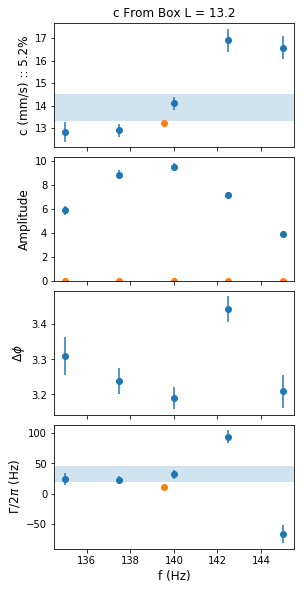

In [230]:
# Calculate all 
cfs = [tp.curve_fit(sinusoidal, guess, 
                    *df_data.loc[f_, 'dn'].trim(xlim=fit_zlim).plotdata) 
       for f_ in movie[0][finds]]
N = len(cfs)
c, ce, f, _ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
a1, a2, a1e, a2e = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
p1, p2, p1e, p2e = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
ka, kae, _, _ = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
for i in range(N):
    f[i] = movie[0][finds[i]]
    a1[i] = cfs[i].fv['amp']
    a2[i] = cfs[i].fv.get('amp2', 0)
    a1e[i] = cfs[i].fe['amp']
    a2e[i] = cfs[i].fe.get('amp2', 0)
    p1[i] = cfs[i].fv['phase']
    p2[i] = cfs[i].fv.get('phase2', 0)
    p1e[i] = cfs[i].fe['phase']
    p2e[i] = cfs[i].fe.get('phase2', 0)
    c[i] = cfs[i].fv['wl'] * f[i] * 1e-6
    ce[i] = cfs[i].fe['wl'] * f[i] * 1e-6
    ka[i] = cfs[i].fv.get('kappa', 0)
    kae[i] = cfs[i].fe.get('kappa', 0)
a1, p1 = fix_amp_phase(a1, p1)
a2, p2 = fix_amp_phase(a2, p2)
dp = (p2-p1)%twopi
dpe = np.sqrt(p1e**2 + p2e**2)
ga = 2 * c * ka * (1e6/twopi)
gae = np.sqrt((2*ce*ka)**2 + (2*c*kae)**2) * (1e6/twopi)

# Averaging c - scaling the errorbars with lorentzian 
c_mean = tp.curve_fit(lambda x, a0=0: x*0 + a0, [1,], f, c, 
             ce / tp.lorentzian(f, modes.loc[m, 'f (Hz)'], modes.loc[m, 'gamma (Hz)']))
c_v, c_e = c_mean.fv[0]*1e3, c_mean.fe[0]*1e3
dc = (c_v - modes.loc[m, 'c (m/s)']*1e3) / (modes.loc[m, 'c (m/s)']*1e3)

ga_mean = tp.curve_fit(lambda x, a0=0: x*0 + a0, [1,], f, ga, 
             gae / tp.lorentzian(f, modes.loc[m, 'f (Hz)'], modes.loc[m, 'gamma (Hz)']))
ga_v, ga_e = ga_mean.fv[0], ga_mean.fe[0]
dga = (ga_v - modes.loc[m, 'gamma (Hz)']) / (modes.loc[m, 'gamma (Hz)'])

# Plots
fig, ax = plt.subplots(nrows=4, figsize=[4,8], sharex=True)
plt.sca(ax[0])
plt.errorbar(f, c*1e3, ce*1e3, fmt='o')
plt.errorbar(modes.loc[m, 'f (Hz)'], 
             modes.loc[m, 'c (m/s)']*1e3, 
             modes.loc[m, 'c (m/s) error']*1e3, fmt='o')
plt.axhspan(c_v - c_e, c_v + c_e, alpha=0.2)
plt.ylabel('c (mm/s) :: {:.1f}%'.format(dc*100), fontsize=12)
plt.title('c From Box L = {:.1f}'.format(modes.loc[m, 'c (m/s)']*1e3), fontsize=12)
plt.sca(ax[1])
plt.errorbar(f, a1, a1e, fmt='o')
plt.errorbar(f, a2, a2e, fmt='o')
plt.ylabel('Amplitude', fontsize=12)
plt.ylim([0, None])
plt.sca(ax[2])
plt.errorbar(f, dp, dpe, fmt='o')
plt.ylabel('$\Delta \phi$', fontsize=12)
plt.sca(ax[3])
plt.errorbar(f, ga, gae, fmt='o')
plt.errorbar(modes.loc[m, 'f (Hz)'], 
             modes.loc[m, 'gamma (Hz)'], 
             modes.loc[m, 'gamma (Hz) error'], fmt='o')
plt.axhspan(ga_v - ga_e, ga_v + ga_e, alpha=0.2)
plt.ylabel('$\Gamma / 2\pi$ (Hz)', fontsize=12)
ax[-1].set_xlabel('f (Hz)', fontsize=12)
plt.tight_layout(pad=0.01)
plt.savefig(suffix_ft + 'SinusoidalFits_{}Mode.pdf'.format(m))

In [231]:
print(c_v, c_e)

13.9230934494 0.600240151641


In [232]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

## Fitting Box Modes 

In [116]:
shift = 0
if zero_z == 'center': shift -= Lum/2
elif zero_z == 'top': shift -= Lum
fit_zlim = (np.array([0 + 0, Lum - 0]))*1e-6 + shift*1e-6
xp = np.linspace(0, Lum, 100) + shift

In [117]:
# Fitting with discrete box modes 
fit_keys = ['a{}'.format(i) for i in range(21)]
guess = {k:1 for k in fit_keys}
fixed = dict(L = Lum * 1.05, phase=0, )

def compute_ft_box_fits_v1(dn_n):
    cf = tp.curve_fit(discrete_modes_v3, guess, *dn_n.trim(xlim=fit_zlim).plotdata, fixed=fixed)
    return (np.array([[i,cf[k]] for i,k in enumerate(fit_keys)]).T, cf)

def temp(test = 32):
    r = df_data.iloc[test]
    c_fit = r['dn/n'].trim(xlim=fit_zlim)
    c_fit = tp.Curve(*c_fit.plotdata)
    ft, cf = compute_ft_box_fits_v1(r['dn/n'])
    # Plot 
    fig, ax = plt.subplots(ncols=2, figsize=[12,4])
    plt.sca(ax[0])
    plt.plot(*r['dn/n'].plotdata)
    plt.plot(xp, cf(xp))
    plt.axvspan(*fit_zlim*1e6, color='k', alpha=0.05)
    plt.axhline(0, c='k', alpha=0.3)
    plt.axvline(0, c='k', alpha=0.3)
    plt.xlim(plot_zlim)
    amp = np.max(np.abs(c_fit.y)) * 2
    plt.ylim([-amp, amp])
    plt.sca(ax[1])
    plt.bar(*ft)
    plt.tight_layout()
    plt.show()
    
    
    
if df_data.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_data.shape[0]-1))

interactive(children=(IntSlider(value=18, description='test', max=18), Output()), _dom_classes=('widget-interact',))

HBox(children=(IntProgress(value=0, max=19), HTML(value='')))

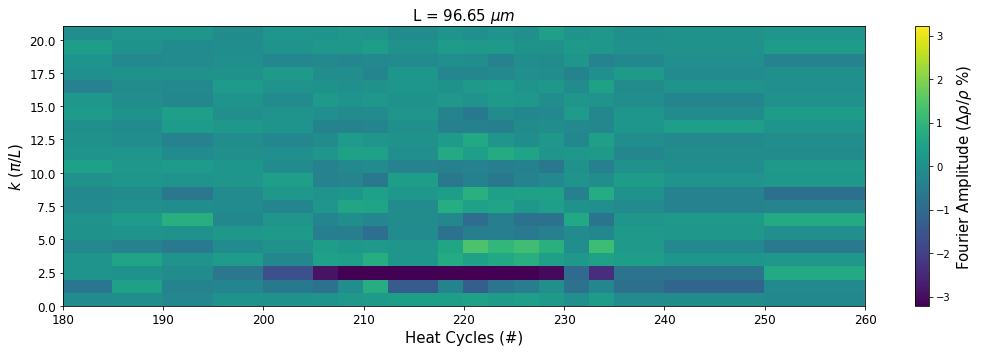

In [118]:
# Compute ft 
ft = [df_data.index.values, np.arange(len(fit_keys)), 
      np.array([compute_ft_box_fits_v1(c)[0][1] for c in tqdm(df_data['dn/n'])]).T]

# Plots 
clim_ft = np.max(np.abs(ft[2])) * 0.5
fig = plt.figure(figsize=[15, 5])
plt.pcolor(*movie_pad(ft), cmap='viridis', vmin=-clim_ft, vmax=clim_ft, linewidth=0)
plt.ylabel(r'$k$ ($\pi/L$)', fontsize=15)
plt.xlabel(x_var_label, fontsize=15)
plt.title(r'L = {:.2f} $\mu m$'.format(Lum), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbr = plt.colorbar()
cbr.set_label(label=r'Fourier Amplitude ($\Delta \rho / \rho$ %)', fontsize=15)
plt.tight_layout()

In [119]:
# Lorentzian Fit Info 
mode_num = np.array([1,2,3,4,5,6,7])
ref_freq_guess = 75
gamma_guess = mode_num * 10

fit_lims = {'1' : [0, 100], '2':[90, 200], '3':[130, 300], '4':[150, 500], '5':[200,600], '6' : [320, 560], '7':[200,700]}
fit_lims = {'1' : [0, 100], '2':[100, 200], '3':[130, 300], '4':[170, 500], }

In [120]:
# Lorentzian Fits 
mode_fits = []

for i,m in enumerate(mode_num):
    ki = np.argmin(np.abs(ft[1] - m))
    guess = dict(x0 = ref_freq_guess*m, gamma = gamma_guess[i], amp=1,)
    c = tp.Curve(ft[0], ft[2][m,:]).trim(xlim=fit_lims.get(str(mode_num[i]), [-np.inf, np.inf]))
    cf = tp.curve_fit(tp.lorentzian, guess, *c.data, plot=False, info=False)
    mode_fits.append(cf)

# Slider plot 
def temp(test = 4):
    ax = mode_fits[test].plot(fiterrors=False)
    ax[0].set_title('mode num {}'.format(mode_num[test]))
    plt.sca(ax[0])
#     if savefig.value: plt.savefig(suffix + 'SampleFits_Mode{}.pdf'.format(mode_num[test]))
    plt.show()
w = ipywidgets.interact(temp, test=(0, len(mode_num)-1))

X and Y limits given leads to too little points. All are being used
CAN'T FIT, Returning Original Guess: Details of Error :: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


interactive(children=(IntSlider(value=4, description='test', max=6), Output()), _dom_classes=('widget-interact',))

In [121]:
# Extract Data 
modes = pd.DataFrame()
modes['mode num'] = mode_num
modes['k (1/m)'] = mode_num * np.pi/Lum * 1e6
modes['f (Hz)'] = [cf['x0'] for cf in mode_fits]
modes['f (Hz) error'] = [cf.fe['x0'] for cf in mode_fits]
modes['f0 (Hz)'] = modes['f (Hz)'] / modes['mode num']
modes['f0 (Hz) error'] = modes['f (Hz) error'] / modes['mode num']
modes['w (1/s)'] = modes['f (Hz)'] * twopi
modes['w (1/s) error'] = modes['f (Hz) error'] * twopi
modes['gamma (Hz)'] = np.abs([cf['gamma'] for cf in mode_fits])
modes['gamma (Hz) error'] = [cf.fe['gamma'] for cf in mode_fits]
modes['gamma (1/s)'] = modes['gamma (Hz)'] * twopi
modes['gamma (1/s) error'] = modes['gamma (Hz) error'] * twopi
modes['FT amplitude (arb.)'] = [cf['amp'] for cf in mode_fits]

modes

,mode num,k (1/m),f (Hz),f (Hz) error,f0 (Hz),f0 (Hz) error,w (1/s),w (1/s) error,gamma (Hz),gamma (Hz) error,gamma (1/s),gamma (1/s) error,FT amplitude (arb.)
0,1,32505.189811,-4.178581e+06,1.300179e+11,-4.178581e+06,1.300179e+11,-2.625480e+07,8.169263e+11,46557.275275,5.316263e+11,292527.987950,3.340307e+12,-15397.891208
1,2,65010.379622,1.500000e+02,NaN,7.500000e+01,NaN,9.424778e+02,NaN,20.000000,NaN,125.663706,NaN,1.000000
2,3,97515.569434,2.199621e+02,3.032387e+00,7.332068e+01,1.010796e+00,1.382062e+03,1.905305e+01,30.434734,1.049454e+01,191.227073,6.593912e+01,0.612469
3,4,130020.759245,2.226925e+02,1.340856e+00,5.567313e+01,3.352139e-01,1.399218e+03,8.424844e+00,11.337195,4.047780e+00,71.233695,2.543295e+01,1.307856
4,5,162525.949056,2.166862e+02,2.108256e+00,4.333724e+01,4.216513e-01,1.361480e+03,1.324657e+01,17.320528,6.924909e+00,108.828089,4.351049e+01,-0.701029
5,6,195031.138867,2.225592e+02,2.250398e+00,3.709320e+01,3.750663e-01,1.398381e+03,1.413967e+01,9.543123,6.705226e+00,59.961209,4.213018e+01,-0.793212
6,7,227536.328679,7.213980e+05,1.501459e+10,1.030569e+05,2.144941e+09,4.532677e+06,9.433945e+10,21874.883040,7.373732e+11,137443.943715,4.633053e+12,418.855613


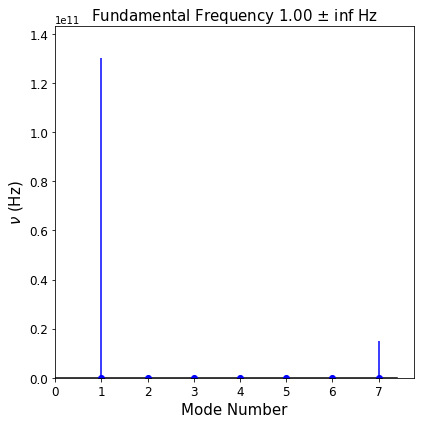

In [122]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['mode num'], modes['f (Hz)'], modes['f (Hz) error'], info=False, plot=False)
xp = np.linspace(0, modes['mode num'].max() + 0.4)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel('Mode Number', fontsize=15)
plt.ylabel(r'$\nu$ (Hz)', fontsize=15)
plt.title(r'Fundamental Frequency {:.2f} $\pm$ {:.2f} Hz '.format(cf[0], cf.fe[0]), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

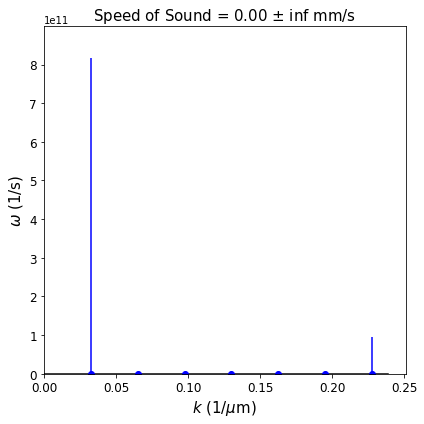

In [123]:
# Plot Freq vs Mode Num 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], fmt='bo')
cf = tp.curve_fit(lambda x, a1=1: a1*x, [1,], modes['k (1/m)']*1e-6, modes['w (1/s)'], modes['w (1/s) error'], info=False, plot=False)
dict_data['speed fit'] = cf
xp = np.linspace(0, modes['k (1/m)'].max()*1e-6 *1.05)
plt.plot(xp, cf(xp), 'k-')
plt.xlim([0, None])
plt.ylim([0, None])
plt.xlabel(r'$k$ (1/$\mu$m)', fontsize=15)
plt.ylabel(r'$\omega$ (1/s)', fontsize=15)
plt.title(r'Speed of Sound = {:.2f} $\pm$ {:.2f} mm/s '.format(cf[0]*1e-3, cf.fe[0]*1e-3), fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

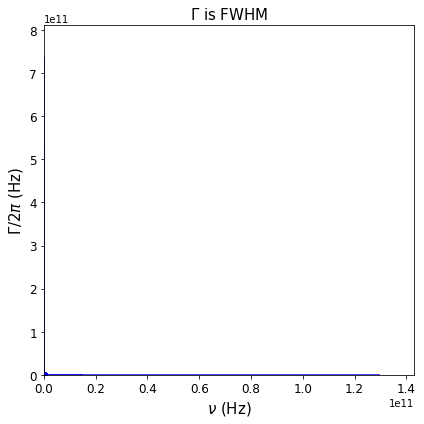

In [124]:
# Plot Gamma vs Freq 
fig, ax = plt.subplots(figsize=[6,6])
plt.errorbar(modes['f (Hz)'], modes['gamma (Hz)'], xerr=modes['f (Hz) error'], yerr=modes['gamma (Hz) error'], fmt='bo')
plt.xlabel(r'$\nu$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(r'$\Gamma$ is FWHM', fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

## Fitting Box Modes - SHGs only

## Free Evolution

In [80]:
mode_num = 2 
res_freq = 160/2

c_ft_t = tp.Curve(ft[0]*1e-3, ft[2][mode_num,:])

          FitValue  FitError Units   Guess  LowerBound  UpperBound  FitError%
freq    175.472404  1.768209  None  160.00        -inf         inf   1.007685
amp     -11.672211  1.822350  None    6.00        -inf         inf  15.612720
phase     0.505103  0.121876  None    0.00        -inf         inf  24.128875
tau       0.018756  0.004298  None    0.02        -inf         inf  22.916963
offset    0.926305  0.386624  None    0.00        -inf         inf  41.738273


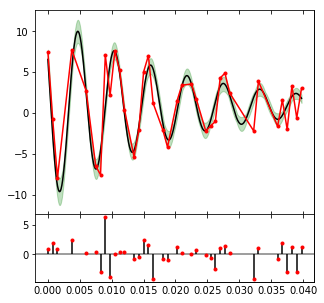

In [81]:
# Fit Exponential Sinusoidal 
def exp_sin(t, freq=100, amp=1, phase=0, tau=1, offset=0,):
    return amp * np.sin(twopi*freq*t - phase) * np.exp(-t/tau) + offset 
guess = dict(freq = res_freq*mode_num, amp=6, phase=0, offset=0, tau=20e-3)
cf = tp.curve_fit(exp_sin, guess, c_ft_t.x, c_ft_t.y, plot=True, info=True)

# Spatial Decay

In [333]:
# Cycle Selector 
_speed = 20e-3
_length = 80e-6
_freq = np.arange(450, 1300, 100)
_cycles = _length / _speed * _freq
for f,c in zip(_freq, _cycles): print('{} -- {:.2f}'.format(f, c))

450 -- 1.80
550 -- 2.20
650 -- 2.60
750 -- 3.00
850 -- 3.40
950 -- 3.80
1050 -- 4.20
1150 -- 4.60
1250 -- 5.00


In [334]:
# Start a figure folder 
display(savefig)
suffix_sd = os.path.join(folder_name, 'Spatial Decay','')
os.makedirs(os.path.join(suffix_sd), exist_ok=True)
suffix_sd

Checkbox(value=True, description='Save Figs')

'07-18-2017_21_40_BoxShaking/Spatial Decay/'

In [335]:
# Dataset Info 
speed_sound_guess = 12 * 1e-3
fit_lims = np.array([10, 60])
plot_lims = np.array([-10, 100])
fit_lims_range_ends = [[10, 30], [60, 80]]

In [336]:
# Function Definitions 
def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(((twopi/wavelength)**2 - (kappa)**2)**(1/2) * x - phase) + a0 + a1*x + a2*x**2

In [337]:
# Prepare for fit 
df_data['fitres'] = None
df_data['fit_guess'] = [dict(wavelength = [speed_sound_guess / r.freq * 1e6, r'$\mu m$', [5, 50]], 
                             kappa = [0.03, r'1/$\mu m$', [0, 0.15]], 
                             amplitude = [2.5, '%', [0, 20]], phase = [0, 'rad'],
                             a0 = 0.1,) 
                        for n,r in df_data.iterrows()]
df_data['fit_fixed'] = [dict() for n,r in df_data.iterrows()]

# Override guess for specific dataset 
df_data.loc[0, 'fit_guess']['a1'] = 0.1

# Remove some data points 
df_data['use'] = True
# df_data.loc[900, 'use'] = True

In [338]:
# Fit and plot 
use = 'dn/n'
test=np.random.randint(0, df_data.shape[0])

def temp_range(test=test, fl1=fit_lims[0], fl2=fit_lims[1], ax=None):
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    fit_lims_range = [np.arange(*fit_lims_range_ends[0], c.dx), np.arange(*fit_lims_range_ends[1], c.dx)]
    fitres_range = []
    for fl in fit_lims_range[0]:
        cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl, fl2]).data, fixed=r.fit_fixed)
        fitres_range.append([fl, cf.fv['wavelength'], cf.fe['wavelength'], cf.fv['kappa'], cf.fe['kappa'],
                             np.abs(cf.fv['amplitude']), cf.fe['amplitude'], cf.fv['phase'], cf.fe['phase']])
    for fl in fit_lims_range[1]:
        cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl1, fl]).data, fixed=r.fit_fixed)
        fitres_range.append([fl, cf.fv['wavelength'], cf.fe['wavelength'], cf.fv['kappa'], cf.fe['kappa'],
                             np.abs(cf.fv['amplitude']), cf.fe['amplitude'], cf.fv['phase'], cf.fe['phase']])
    fr = np.array(fitres_range).T
    if ax is not None:
        # Plot wavleength 
        ax[0].errorbar(fr[0], fr[1], fr[2], fmt='bo')
        ax[0].axhline(np.mean(fr[1]), color='b', alpha=0.5)
        ax[0].axhline(np.mean(fr[1]) * 0.95, color='b', alpha=0.5, linestyle='--', label=r'$\pm$ 5%')
        ax[0].axhline(np.mean(fr[1]) * 1.05, color='b', alpha=0.5, linestyle='--')
        ax[0].legend(loc=0, fontsize=12)
        ax[0].set(ylabel=r'Wavelength ($\mu m$)')
        
        ax[1].errorbar(fr[0], fr[3], fr[4], fmt='ro')
        ax[1].axhline(np.mean(fr[3]), color='r', alpha=0.5)
        ax[1].axhline(np.mean(fr[3]) * 0.85, color='r', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[1].axhline(np.mean(fr[3]) * 1.15, color='r', alpha=0.5, linestyle='--')
        ax[1].legend(loc=0, fontsize=12)
        ax[1].set(ylabel=r'$\kappa$ ($1 /\mu m$)')
        
        ax[2].errorbar(fr[0], fr[5], fr[6], fmt='bo')
        ax[2].axhline(np.mean(fr[5]), color='b', alpha=0.5)
        ax[2].axhline(np.mean(fr[5]) * 0.85, color='b', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[2].axhline(np.mean(fr[5]) * 1.15, color='b', alpha=0.5, linestyle='--')
        ax[2].legend(loc=0, fontsize=12)
        ax[2].set(ylabel=r'Amplitude $\Delta \rho / \rho$ (%)')
        
        ax[3].errorbar(fr[0], fr[7], fr[8], fmt='ro')
        ax[3].axhline(np.mean(fr[7]), color='r', alpha=0.5)
        ax[3].axhline(np.mean(fr[7]) * 0.85, color='r', alpha=0.5, linestyle='--', label=r'$\pm$ 15%')
        ax[3].axhline(np.mean(fr[7]) * 1.15, color='r', alpha=0.5, linestyle='--')
        ax[3].legend(loc=0, fontsize=12)
        ax[3].set(ylabel=r'phase (rad)')
        
    return fr


def temp_plot(test=test, fl1=fit_lims[0], fl2=fit_lims[1], amp=0):
    # Load Data 
    r = df_data.iloc[test]
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    xp = np.linspace(plot_lims[0], plot_lims[1], 1000)
    
    # Plot figure 
    fig = plt.figure(figsize=[10, 10])
    ax = []
    ax.append(plt.subplot2grid([3,1], [0,0],))
    ax.append(plt.subplot2grid([3,2], [1,0],))
    ax.append(plt.subplot2grid([3,2], [1,1],))
    ax.append(plt.subplot2grid([3,2], [2,0],))
    ax.append(plt.subplot2grid([3,2], [2,1],))
    
    # Compute cf at given [fl1, fl2]
    cf = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=[fl1, fl2]).data, fixed=r.fit_fixed)
    
    # Plots 
    plt.sca(ax[0])
    plt.plot(xp, cf(xp), 'C1')
    plt.plot(*c.plotdata, '.-C0')
    plt.axvline(0, c='k', linestyle='--', )
    plt.axvline(r.length*1e6, c='k', linestyle='--', )
    plt.axhline(0, c='k', linestyle='-', alpha=0.5)
    plt.axvspan(fl1, fl2, alpha=0.05, color='k', label='Fourier Width')
    plt.plot(c.x, cf(c.x, amplitude=0), 'C2-', alpha=0.5)
    amp_ = abs(cf['amplitude']) * 1.5
    amp_ += abs(cf(np.array([0]), phase=np.pi/2)[0])
    if amp_ >= 10: amp_ = 9.99
    if amp == 0.0: amp = amp_
    plt.ylim([-amp, amp])
    plt.xlim(plot_lims)
    plt.xlabel(r'z ($\mu m$)', fontsize=12)
    plt.ylabel(r'$\Delta \rho / \rho$ (%)', fontsize=12)
    plt.title("{} = {}".format(x_var_label, r.name), fontsize=12)
    
    # Compute range of fits 
    fr = temp_range(test, fl1, fl2, ax=ax[1:])
    
    plt.tight_layout()
    plt.show()
    if savefig.value: fig.savefig(suffix_samples + 'SpatialDecayFit-{}.pdf'.format(r.name))
    
if df_data.shape[0] == 1: temp_plot(0, True, 0)
else: ipywidgets.interact(temp_plot, test=(0, df_data.shape[0]-1), amp=(0, 20, 1), fl1=(0, 40, 2), fl2=(50, 96, 2))

interactive(children=(IntSlider(value=6, description='test', max=17), IntSlider(value=10, description='fl1', max=40, step=2), IntSlider(value=60, description='fl2', max=96, min=50, step=2), IntSlider(value=0, description='amp', max=20), Output()), _dom_classes=('widget-interact',))

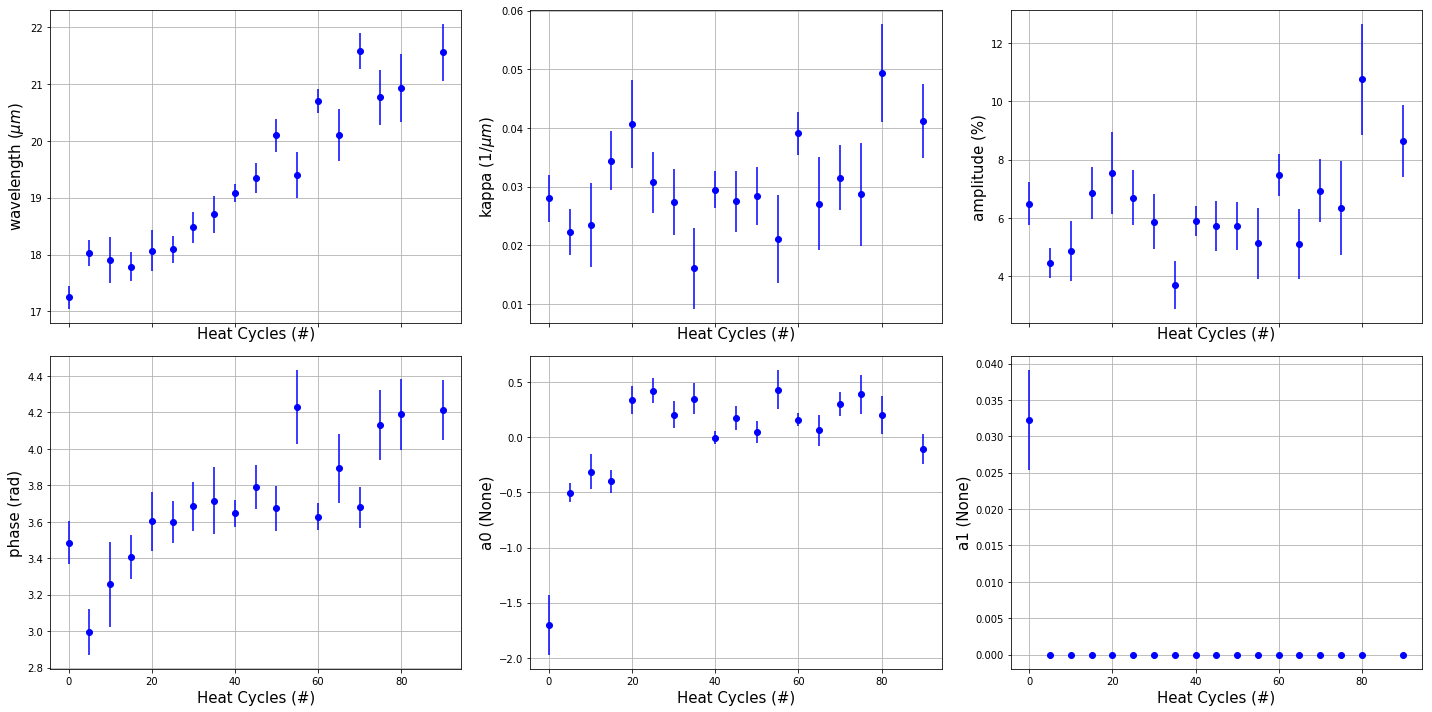

In [339]:
# Fit all and raw plot 
for n,r in df_data.iterrows():
    c = tp.Curve(r[use].x*1e6, r[use].y * 100)
    df_data.loc[r.name, 'fitres'] = tp.curve_fit(sin_decay, r.fit_guess, *c.trim(xlim=fit_lims).data, fixed=r.fit_fixed)

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres['amplitude'] < 0:
        r.fitres.fr.loc['amplitude','FitValue'] = - r.fitres['amplitude']
        r.fitres.fr.loc['phase','FitValue'] = r.fitres['phase'] + np.pi
    r.fitres.fr.loc['phase','FitValue'] = np.mod(r.fitres.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres.fr.index.values
fu_ = df_data.iloc[0].fitres.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='ro')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].set_xlabel(x_var_label, fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'RawFits-v1.pdf')

In [340]:
# Compute Fit results 
decay = pd.DataFrame(index = df_data.index.values)
decay['x'] = df_data.index.values
decay['x error'] = df_data.index.values * 0
decay['frequency (Hz)'] = df_data.freq.values
decay['frequency (Hz) error'] = df_data.freq.values * 0
decay['omega (1/s)'] = decay['frequency (Hz)'] * twopi
decay['omega (1/s) error'] = decay['frequency (Hz) error'] * twopi
decay['omega (1/ms)'] = decay['omega (1/s)'] * 1e-3
decay['omega (1/ms) error'] = decay['omega (1/s) error'] * 1e-3
decay['wavelength (um)'] = [fr.fv['wavelength'] for fr in df_data.fitres]
decay['wavelength (um) error'] = [fr.fe['wavelength'] for fr in df_data.fitres]
decay['wavelength (m)'] = decay['wavelength (um)'] * 1e-6
decay['wavelength (m) error'] = decay['wavelength (um) error'] * 1e-6
decay['k (1/m)'] = twopi / decay['wavelength (m)']
decay['k (1/m) error'] = twopi * decay['wavelength (m) error'] / decay['wavelength (m)']**2
decay['k (1/um)'] = decay['k (1/m)'] * 1e-6
decay['k (1/um) error'] = decay['k (1/m) error'] * 1e-6
decay['speed (m/s)'] = decay['wavelength (m)'] * decay['frequency (Hz)']
decay['speed (m/s) error'] = decay['wavelength (m) error'] * decay['frequency (Hz)']
decay['speed (mm/s)'] = decay['speed (m/s)'] * 1e3
decay['speed (mm/s) error'] = decay['speed (m/s) error'] * 1e3
decay['kappa (1/um)'] = [fr.fv['kappa'] for fr in df_data.fitres]
decay['kappa (1/um) error'] = [fr.fe['kappa'] for fr in df_data.fitres]
decay['kappa (1/m)'] = decay['kappa (1/um)'] * 1e6
decay['kappa (1/m) error'] = decay['kappa (1/um) error'] * 1e6
decay['gamma (1/s)'] = 2 * decay['speed (m/s)'] * decay['kappa (1/m)']
decay['gamma (1/s) error'] = 2 * np.sqrt((decay['speed (m/s) error'] * decay['kappa (1/m)'])**2 + (decay['speed (m/s)'] * decay['kappa (1/m) error'])**2)
decay['gamma (Hz)'] = decay['gamma (1/s)'] / twopi
decay['gamma (Hz) error'] = decay['gamma (1/s) error'] / twopi
decay['1/Q'] = decay['gamma (1/s)'] / decay['omega (1/s)']
decay['1/Q error'] = decay['gamma (1/s) error'] / decay['omega (1/s)']
decay['Q'] = decay['omega (1/s)'] / decay['gamma (1/s)']
decay['Q error'] = (decay['omega (1/s)'] / decay['gamma (1/s)']**2) * decay['gamma (1/s) error']
decay['amplitude (%)'] = [fr.fv['amplitude'] for fr in df_data.fitres]
decay['amplitude (%) error'] = [fr.fe['amplitude'] for fr in df_data.fitres]

# Save Data to Excel 
if savefig.value: decay.to_excel(suffix_sd + 'SpatialDecay-Data.xlsx')
# print(decay.iloc[0])
decay.iloc[0]

x                        0.000000e+00
x error                  0.000000e+00
frequency (Hz)           7.000000e+02
frequency (Hz) error     0.000000e+00
omega (1/s)              4.398230e+03
omega (1/s) error        0.000000e+00
omega (1/ms)             4.398230e+00
omega (1/ms) error       0.000000e+00
wavelength (um)          1.724810e+01
wavelength (um) error    1.985473e-01
wavelength (m)           1.724810e-05
wavelength (m) error     1.985473e-07
k (1/m)                  3.642827e+05
k (1/m) error            4.193351e+03
k (1/um)                 3.642827e-01
k (1/um) error           4.193351e-03
speed (m/s)              1.207367e-02
speed (m/s) error        1.389831e-04
speed (mm/s)             1.207367e+01
speed (mm/s) error       1.389831e-01
kappa (1/um)             2.802568e-02
kappa (1/um) error       4.011917e-03
kappa (1/m)              2.802568e+04
kappa (1/m) error        4.011917e+03
gamma (1/s)              6.767457e+02
gamma (1/s) error        9.718985e+01
gamma (Hz)  

## Amplitude Dependence

In [ ]:
# Main Plot 
keys = ['amplitude (%)', 'gamma (Hz)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
cf = tp.curve_fit(lambda x, a1=0, a0=0: a1*x + a0, [1,1], *xyz, info=True)
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.plot(xp, cf(xp), 'k--', label=r'{:.2f} + {:.2f} x'.format(cf['a0'], cf['a1']))
plt.xlabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.title(r'Amplitude Response of Spatial Decay at {} Hz'.format(decay['frequency (Hz)'].iloc[0]), fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'GammaVsAmp_v1.pdf')

In [ ]:
# Main Plot 
keys = ['amplitude (%)', 'speed (mm/s)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
cf = tp.curve_fit(lambda x, a0=0: x*0 + a0, [1,], *xyz, info=True)
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.plot(xp, cf(xp), 'k--')
plt.xlabel(r'$\Delta \rho / \rho$ (%)', fontsize=15)
plt.ylabel(r'$c$ (mm/s)', fontsize=15)
plt.title(r'Amplitude Response of Spatial Decay at {} Hz'.format(decay['frequency (Hz)'].iloc[0]), fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
perc = 10/100
plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'SpeedVsAmp_v1.pdf')

In [ ]:
# Plot overlaping profiles 


## Frequency Dependence

In [ ]:
# Main Plot 
keys = ['frequency (Hz)', 'gamma (Hz)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
cf2 = tp.curve_fit(lambda x, a2=0: x**2 * a2, [1,], *xyz, info=True)
eta_rho = [3/4 * cst.mass / cst.hbar * cf2.fv[0] /twopi * np.mean(decay['speed (m/s)'])**2, 
          3/4 * cst.mass / cst.hbar * cf2.fe[0] /twopi * np.mean(decay['speed (m/s)'])**2]
plt.plot(xp, cf2(xp), 'k--', label=r'$\eta / \rho = {:.2f} \pm {:.2f} \: \hbar/m$'.format(*eta_rho))
cf1 = tp.curve_fit(lambda x, a1=0, a0=0: x * a1 + a0, [1,1], *xyz, info=True)
plt.plot(xp, cf1(xp), 'r--')
plt.xlabel(r'$\omega / 2 \pi$ (Hz)', fontsize=15)
plt.ylabel(r'$\Gamma / 2 \pi$ (Hz)', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
perc = 10/100
# plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()

In [ ]:
# Dispersion Relation 
keys = ['k (1/um)', 'omega (1/ms)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
cf = tp.curve_fit(lambda x, a1=0, a0=0: x * a1 + a0, [1,], *xyz[0:2], info=True)
plt.plot(xp, cf(xp), 'r-')
plt.xlabel(r'$k$ $(1/\mu m)$', fontsize=15)
plt.ylabel(r'$\omega$ $(1/ms)$', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.xlim([0, None])
plt.ylim([0, None])
plt.tight_layout()

## Temperature Dependence

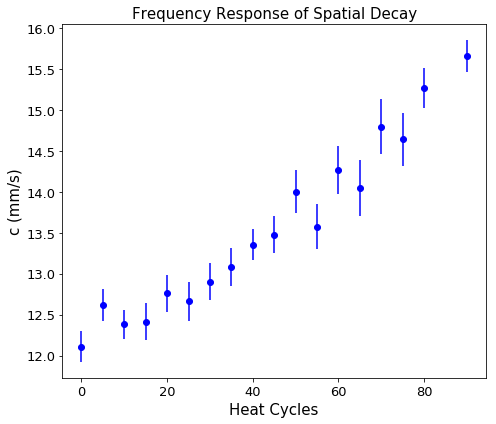

In [346]:
# Main Plot 
keys = ['x', 'speed (mm/s)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.xlabel(r'Heat Cycles', fontsize=15)
plt.ylabel(r'c (mm/s)', fontsize=15)
plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
# plt.xlim([0, None])
perc = 10/100
# plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()

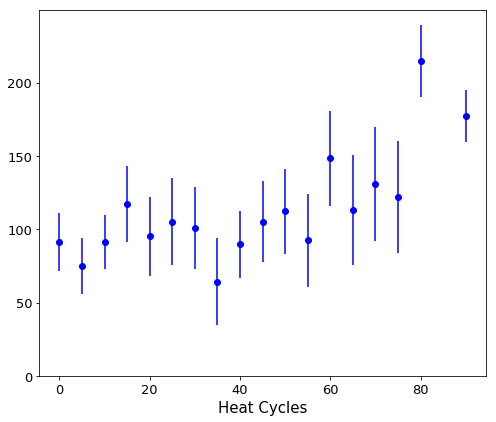

In [347]:
# Main Plot 
keys = ['x', 'gamma (Hz)']
xyz = [decay[keys[0]].values, decay[keys[1]].values, decay[keys[1] + ' error'].values]
fig,ax = plt.subplots(figsize=[7,6])
plt.errorbar(*xyz, xerr=decay[keys[0] + ' error'], fmt = 'bo')
xp = np.linspace(0, np.max(xyz[0])* 1.1, )
plt.xlabel(r'Heat Cycles', fontsize=15)
# plt.ylabel(r'c (mm/s)', fontsize=15)
# plt.title(r'Frequency Response of Spatial Decay', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
# plt.xlim([0, None])
plt.ylim([0, None])
perc = 10/100
# plt.ylim([cf['a0'] * (1-perc), cf['a0'] * (1+perc)])
plt.tight_layout()

## Different Fitting

    FitValue  FitError Units  Guess  LowerBound  UpperBound   FitError%
a0  0.618072  0.705571  None  -0.50        -inf         inf  114.156750
a1 -0.008957  0.015017  None   0.01        -inf         inf  167.653575
             FitValue  FitError Units  Guess  LowerBound  UpperBound  FitError%
wavelength  20.502165  0.183460    um  17.00         1.0       100.0   0.894834
kappa        0.023258  0.006404  1/um   0.02         0.0         0.1  27.534703
amplitude    4.707738  0.927121     %   3.00         0.0        10.0  19.693554
phase        3.500000  0.000000   NaN   3.50         3.5         3.5   0.000000
a0           0.000000  0.000000   NaN   0.00         0.0         0.0   0.000000
a1           0.000000  0.000000   NaN   0.00         0.0         0.0   0.000000
a2           0.000000  0.000000   NaN   0.00         0.0         0.0   0.000000


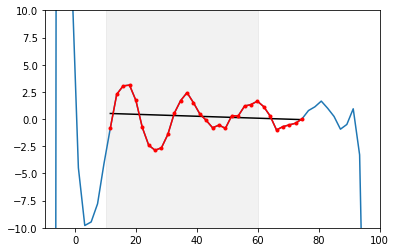

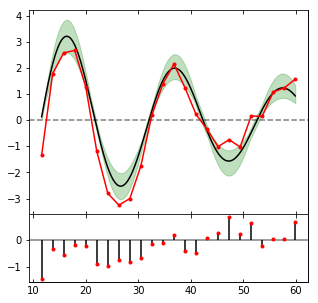

In [343]:
test = 10
fit_range = np.array([10, 60])
line_range = np.array([10, 75])
guess = dict(wavelength=[17, [1,100], 'um'], 
             kappa = [0.02, [0, 0.1], '1/um'], 
             amplitude = [3, [0, 10], '%'])
fixed = dict(phase = 3.5)

r = df_data.iloc[test]
call = tp.Curve(*r['dn/n'].plotdata)
c4line = call.trim(xlim=line_range)
cfline = tp.curve_fit(lambda x, a0=0, a1=0: a1*x + a0, [-0.5,0.01], *c4line.data, plot=False, info=True)
c4fit = call.trim(xlim=fit_range)
c4fit = tp.Curve(c4fit.x, c4fit.y - cfline(c4fit.x))
def sin_decay(x, wavelength=1, kappa=0, amplitude=1, phase=0, a0=0, a1=0, a2=0):
    return amplitude * np.exp(- x * kappa) * np.sin(((twopi/wavelength)**2 - (kappa)**2)**(1/2) * x - phase) + a0 + a1*x + a2*x**2
cfdata = tp.curve_fit(sin_decay, guess, *c4fit.data, plot=False, info=True, fixed=fixed)

fig, ax = plt.subplots()
plt.plot(*call.data)
cfline.plot_fitdata(ax=ax)
plt.axvspan(*fit_range, color='k', alpha=0.05)
plt.ylim([-10, 10])
plt.xlim([-10, 100])

ax = cfdata.plot()
ax[0].axhline(0, color='k', linestyle='--', alpha=0.5)


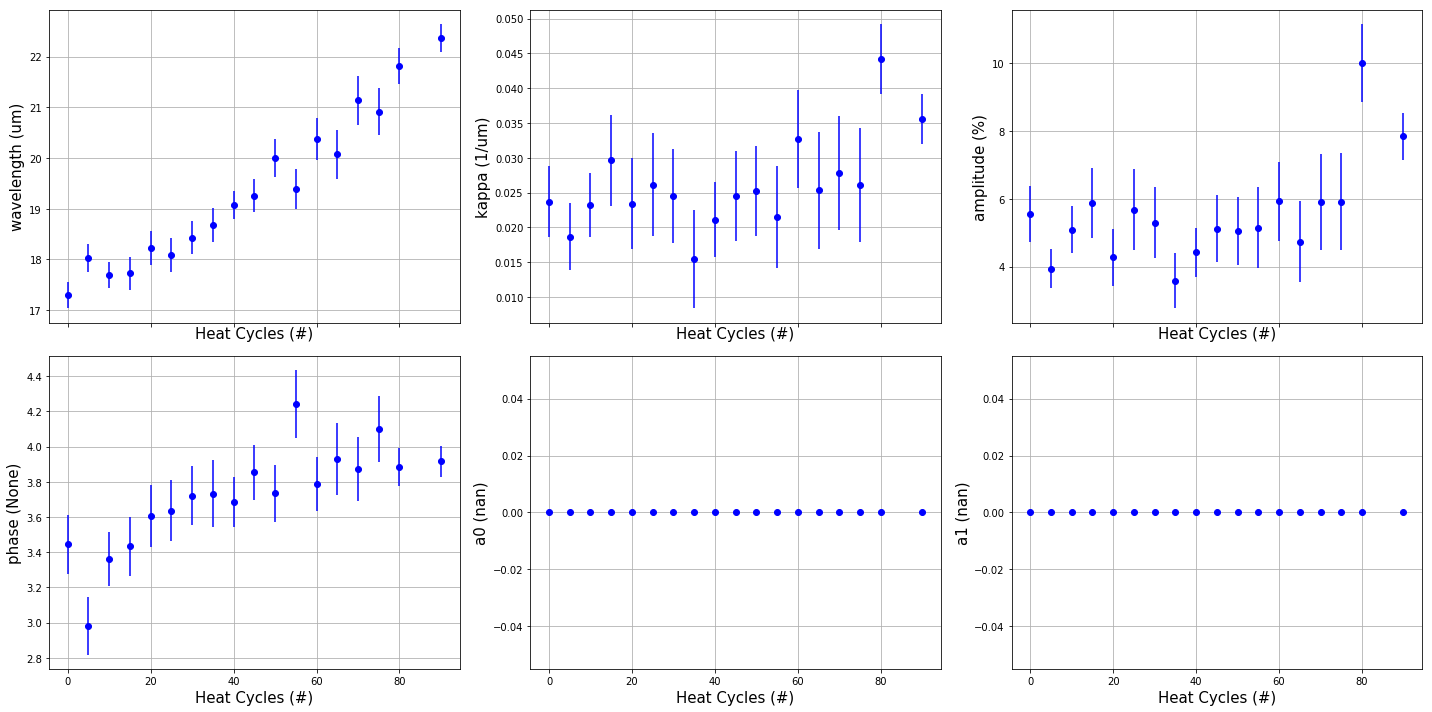

In [344]:
# Fit all and raw plot 
df_data['fitres'] = None
df_data['use'] = True
guess = dict(wavelength=[20, [1,100], 'um'], 
             kappa = [0.025, [0, 1/10], '1/um'], 
             amplitude = [4.5, [0, 10], '%'], phase=3.75)

for n,r in df_data.iterrows():
    call = tp.Curve(*r['dn/n'].plotdata)
    c4line = call.trim(xlim=line_range)
    cfline = tp.curve_fit(lambda x, a0=0, a1=0: a1*x + a0, [-0.5,0.01], *c4line.data, plot=False, info=False)
    c4fit = call.trim(xlim=fit_range)
    c4fit = tp.Curve(c4fit.x, c4fit.y - cfline(c4fit.x))
    df_data.loc[r.name, 'fitres'] = tp.curve_fit(sin_decay, guess, *c4fit.data, )

# Fix phase and amp 
for n,r in df_data.iterrows():
    if r.fitres['amplitude'] < 0:
        r.fitres.fr.loc['amplitude','FitValue'] = - r.fitres['amplitude']
        r.fitres.fr.loc['phase','FitValue'] = r.fitres['phase'] + np.pi
    r.fitres.fr.loc['phase','FitValue'] = np.mod(r.fitres.fr.loc['phase','FitValue'], twopi)

# Plot 
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[20,10], sharex=True)
fn_ = df_data.iloc[0].fitres.fr.index.values
fu_ = df_data.iloc[0].fitres.fr['Units'].values
ax = ax.flatten()
for i in range(6):
    ax[i].errorbar(df_data[df_data.use].index.values, [fr.fv[i] for fr in df_data[df_data.use].fitres], [fr.fe[i] for fr in df_data[df_data.use].fitres], fmt='bo')
    ax[i].errorbar(df_data[~df_data.use].index.values, [fr.fv[i] for fr in df_data[~df_data.use].fitres], [fr.fe[i] for fr in df_data[~df_data.use].fitres], fmt='ro')
    ax[i].set_ylabel("{} ({})".format(fn_[i], fu_[i]), fontsize=15)
    ax[i].set_xlabel(x_var_label, fontsize=15)
    ax[i].grid()
plt.tight_layout()
if savefig.value: fig.savefig(suffix_sd + 'RawFits-v1.pdf')

In [345]:
# Compute Fit results 
decay = pd.DataFrame(index = df_data.index.values)
decay['x'] = df_data.index.values
decay['x error'] = df_data.index.values * 0
decay['frequency (Hz)'] = df_data.freq.values
decay['frequency (Hz) error'] = df_data.freq.values * 0
decay['omega (1/s)'] = decay['frequency (Hz)'] * twopi
decay['omega (1/s) error'] = decay['frequency (Hz) error'] * twopi
decay['omega (1/ms)'] = decay['omega (1/s)'] * 1e-3
decay['omega (1/ms) error'] = decay['omega (1/s) error'] * 1e-3
decay['wavelength (um)'] = [fr.fv['wavelength'] for fr in df_data.fitres]
decay['wavelength (um) error'] = [fr.fe['wavelength'] for fr in df_data.fitres]
decay['wavelength (m)'] = decay['wavelength (um)'] * 1e-6
decay['wavelength (m) error'] = decay['wavelength (um) error'] * 1e-6
decay['k (1/m)'] = twopi / decay['wavelength (m)']
decay['k (1/m) error'] = twopi * decay['wavelength (m) error'] / decay['wavelength (m)']**2
decay['k (1/um)'] = decay['k (1/m)'] * 1e-6
decay['k (1/um) error'] = decay['k (1/m) error'] * 1e-6
decay['speed (m/s)'] = decay['wavelength (m)'] * decay['frequency (Hz)']
decay['speed (m/s) error'] = decay['wavelength (m) error'] * decay['frequency (Hz)']
decay['speed (mm/s)'] = decay['speed (m/s)'] * 1e3
decay['speed (mm/s) error'] = decay['speed (m/s) error'] * 1e3
decay['kappa (1/um)'] = [fr.fv['kappa'] for fr in df_data.fitres]
decay['kappa (1/um) error'] = [fr.fe['kappa'] for fr in df_data.fitres]
decay['kappa (1/m)'] = decay['kappa (1/um)'] * 1e6
decay['kappa (1/m) error'] = decay['kappa (1/um) error'] * 1e6
decay['gamma (1/s)'] = 2 * decay['speed (m/s)'] * decay['kappa (1/m)']
decay['gamma (1/s) error'] = 2 * np.sqrt((decay['speed (m/s) error'] * decay['kappa (1/m)'])**2 + (decay['speed (m/s)'] * decay['kappa (1/m) error'])**2)
decay['gamma (Hz)'] = decay['gamma (1/s)'] / twopi
decay['gamma (Hz) error'] = decay['gamma (1/s) error'] / twopi
decay['1/Q'] = decay['gamma (1/s)'] / decay['omega (1/s)']
decay['1/Q error'] = decay['gamma (1/s) error'] / decay['omega (1/s)']
decay['Q'] = decay['omega (1/s)'] / decay['gamma (1/s)']
decay['Q error'] = (decay['omega (1/s)'] / decay['gamma (1/s)']**2) * decay['gamma (1/s) error']
decay['amplitude (%)'] = [fr.fv['amplitude'] for fr in df_data.fitres]
decay['amplitude (%) error'] = [fr.fe['amplitude'] for fr in df_data.fitres]

# Save Data to Excel 
if savefig.value: decay.to_excel(suffix_sd + 'SpatialDecay-Data.xlsx')
# print(decay.iloc[0])
decay.iloc[0]

x                        0.000000e+00
x error                  0.000000e+00
frequency (Hz)           7.000000e+02
frequency (Hz) error     0.000000e+00
omega (1/s)              4.398230e+03
omega (1/s) error        0.000000e+00
omega (1/ms)             4.398230e+00
omega (1/ms) error       0.000000e+00
wavelength (um)          1.729925e+01
wavelength (um) error    2.648511e-01
wavelength (m)           1.729925e-05
wavelength (m) error     2.648511e-07
k (1/m)                  3.632056e+05
k (1/m) error            5.560670e+03
k (1/um)                 3.632056e-01
k (1/um) error           5.560670e-03
speed (m/s)              1.210948e-02
speed (m/s) error        1.853958e-04
speed (mm/s)             1.210948e+01
speed (mm/s) error       1.853958e-01
kappa (1/um)             2.366426e-02
kappa (1/um) error       5.081118e-03
kappa (1/m)              2.366426e+04
kappa (1/m) error        5.081118e+03
gamma (1/s)              5.731235e+02
gamma (1/s) error        1.233718e+02
gamma (Hz)  

## Image Bootstrap 

In [481]:
df_data.iloc[0]

data_ind       name
07-28-2017_00_53_00_TopA    False
07-28-2...
# data                                                         2
bg_ind         name
07-28-2017_00_53_00_TopA     True
07-28-2...
# bg                                                          19
length                                               8.66173e-05
freq                                                         150
cycles                                                     0.841
nz data all    [A curve with 266 data points., A curve with 2...
nz bg all      [A curve with 266 data points., A curve with 2...
nz data                            A curve with 266 data points.
nz bg                              A curve with 266 data points.
box fit bg     [-4.06791081741e-09, 8.6615345589e-05, 3.07736...
dn                                 A curve with 266 data points.
dn/n                               A curve with 266 data points.
2d dn          [[-1.69337489998, 0.0212891362952, 1.550409084...
Name: 150.0, dtype: objec

In [524]:
i = 2

use_data = df.index[df_data['data_ind'].iloc[i]].values
use_data = np.random.choice(use_data, 2, replace=False)

use_bg = df.index[df_data['bg_ind'].iloc[i]].values
use_bg = np.random.choice(use_bg, 2, replace=False)

df.loc[use_data]

ValueError: Cannot take a larger sample than population when 'replace=False'

# Energy Expansion

Total energy per particle in the Hybrid potential
$$\frac{E}{N} = 2 m \omega^2 \left< z^2 \right> = 4 \left< U \right>$$

Reduced Energy 
$$ \frac{E}{E_0} = \frac{5}{3} \frac{E}{N E_F}$$

Here $  \left< U \right> $ is the normalized averages, normalized by the total atom numbers. 

We will employ two ways to extract the energy. 
* Equation of State Fits
* Second Moment

## Bunch of Calcs

In [2092]:
df_hyb_energy_all = pd.DataFrame()

In [2093]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles','HeatCycles']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)','Heat Cycles (#)']
usei = 3
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [2094]:
# Import from Clipboard 
df_hyb_energy_all = tp.images_from_clipboard(df=df_hyb_energy_all,
                                         x=x_var_name, 
                                         params=import_params,
                                         image_func=tp.Hybrid_Image,
                                         download=image_use,
                                         display=True)

Updating the local database...
Done

Total Number of Shots 3, Images 3


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,ShakingCycles2,BoxShakeFreq2,BoxShakeTime2,BoxShakeAmp2,SeqMode,GradientOffset,GradientShakeAmp,GradientShakeFreq,GradientShakeCycle,x
name,,,,,,,,,,,,,,,,,,,,,
07-05-2018_21_40_47_TopA,0.000000,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0
07-05-2018_21_41_44_TopA,0.966667,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0
07-05-2018_21_42_56_TopA,2.166667,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0


In [2095]:
# Start a figure folder 
display(savefig)
suffix_energy = os.path.join(folder_name, 'Energy','')
os.makedirs(os.path.join(suffix_energy), exist_ok=True)
suffix_energy

'07-05-2018_20_24_BoxShaking\\Energy\\'

In [2110]:
# Define Settings 

settings = {**default_settings, 
            **dict(center_x = 1183, center_y = 1350, 
                   fudge=1.86, width=800, height=1100, 
                   subsample=3,
                   radial_selection=0.75,
                   Tfit_lim=0.1)}

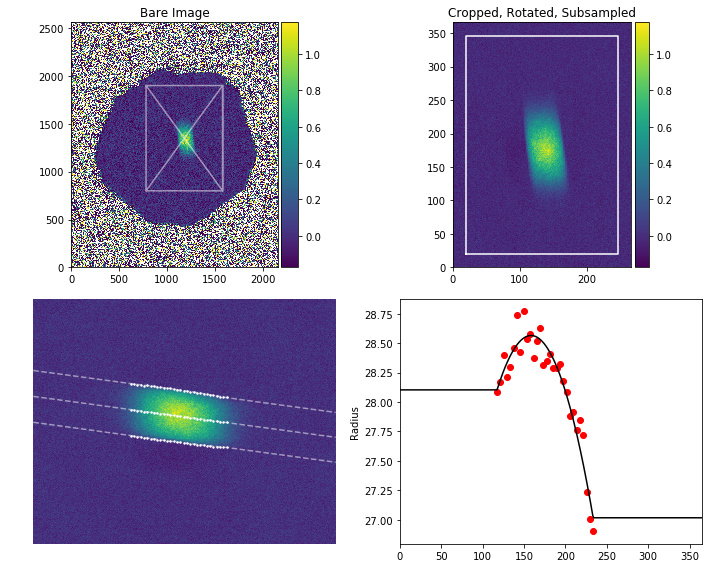

In [2112]:
# Verify Settings 

# Apply to all Images 
for n,r in df_hyb_energy_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_hyb_energy_all.shape[0])):
    r = df_hyb_energy_all.iloc[test]
    ax = plt.subplots(nrows=2, ncols=2, figsize=[10,8])[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    r.image.xsec.infoplot(axs=ax[2:4])
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'Energy Crop Cross Section {}.pdf'.format(r.name[11:16]))

if df_hyb_energy_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_hyb_energy_all.shape[0]-1))


Total Images 3 ==> Good 3, Bad 0


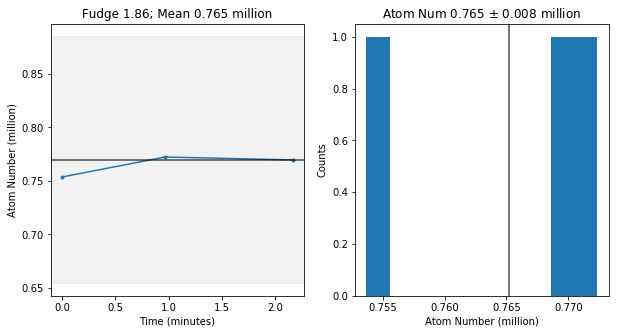

In [2113]:
# Atom Number Filter 
df_hyb_energy_all['total_atoms'] = [im.total_atoms for im in tqdm(df_hyb_energy_all.image)]
ax = tp.atom_num_filter(df=df_hyb_energy_all, keep=0.15, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
if savefig.value: plt.savefig(suffix_energy + 'AtomNumbersScatter.pdf')
df_hyb_energy = df_hyb_energy_all[df_hyb_energy_all.use]

In [2114]:
# Compute E/N and E/E0 for the three nz's 
def compute_moment(nz, zlim=550, trap_f=settings['trap_f']):
    mult = 4 * 1/2 * cst.mass * (twopi*trap_f)**2
    using = (nz.x >= -zlim*1e-6) & (nz.x <= zlim*1e-6)
    nz = tp.Curve(nz.x[using], nz.y[using])
    return mult * np.trapz(nz.y*nz.x**2, nz.x) / np.trapz(nz.y, nz.x)

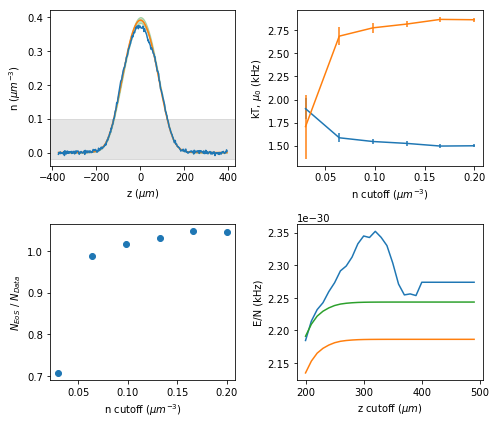

In [2115]:
# Fit kT and mu0 vs fit lims 
cutoffs = np.linspace(0.03, 0.2, 6)
zlims = np.arange(200, 500, 10)
guess = dict(kT_kHz = settings['Tfit_guess_kT'],
             mu0_kHz = settings['Tfit_guess_mu0'],)
fixed = dict(trap_f=df_hyb_energy.iloc[0].image.trap_f, z0=0, fudge=1, offset=0, gradient=0)

def sample_EoS_fitrange(test=np.random.randint(0, df_hyb_energy.shape[0])): 
    # Extract needed variables for easy access 
    r = df_hyb_energy.iloc[test]
    img = r.image
    # Fit thermodynamic function n(z) 
    cf = tp.curve_fit(tp.density_unitary_hybrid, guess, 
                 *img.nz.trim(ylim=[-np.inf, settings['Tfit_lim'] * 1e18]).data, 
                 plot = False, fixed = fixed)
    # Fit thermodynamics to a range of density cutoffs 
    cfs = [tp.curve_fit(tp.density_unitary_hybrid, guess, 
                 *img.nz.trim(ylim=[-np.inf, c * 1e18]).data, 
                 plot = False, fixed = fixed) 
          for c in tqdm(cutoffs)]
    atoms_ratio = [c(img.nz.x).sum() / img.nz.y.sum() for c in cfs]
    # Compute moment vs zlim 
    z, n_data = img.nz.x, img.nz.y
    n_fit = cf(z)
    n_stitched = n_data.copy()
    n_stitched[n_fit <= settings['Tfit_lim'] * 1e18] = n_fit[n_fit <= settings['Tfit_lim'] * 1e18]
    moment_data = [compute_moment(tp.Curve(z, n_data), zl) for zl in zlims]
    moment_fit = [compute_moment(tp.Curve(z, n_fit), zl) for zl in zlims]
    moment_stitched = [compute_moment(tp.Curve(z, n_stitched), zl) for zl in zlims]
    
    # Plot Results 
    ax = plt.subplots(ncols=2, nrows=2, figsize=[7, 6])[1].flatten()
    ax[0].axhspan(2*cf.y.min()/1e18, settings['Tfit_lim'], color='k', alpha=0.1)
    ax[0].plot(*img.nz.plotdata, zorder=2)
    ax[0].plot(cf.xp*1e6, cf(cf.xp)/1e18, zorder=1)
    ax[0].fill_between(cf.xp*1e6, cf.yband(cf.xp)[0]/1e18, 
                       cf.yband(cf.xp)[1]/1e18, color='g', alpha=0.25, zorder=0)
    ax[1].errorbar(cutoffs, [c.fv['kT_kHz'] for c in cfs], [c.fe['kT_kHz'] for c in cfs])
    ax[1].errorbar(cutoffs, [c.fv['mu0_kHz'] for c in cfs], [c.fe['mu0_kHz'] for c in cfs])
    ax[2].plot(cutoffs, atoms_ratio, 'o')
    ax[3].plot(zlims, moment_data, '-')
    ax[3].plot(zlims, moment_fit, '-')
    ax[3].plot(zlims, moment_stitched, '-')
    ax[0].set(xlabel=r'z ($\mu m$)', ylabel=r'n ($\mu m^{-3}$)')
    ax[1].set(xlabel=r'n cutoff ($\mu m^{-3}$)', ylabel=r'kT, $\mu_0$ (kHz)')
    ax[2].set(xlabel=r'n cutoff ($\mu m^{-3}$)', ylabel=r'$N_{EoS}$ / $N_{Data}$')
    ax[3].set(xlabel=r'z cutoff ($\mu m$)', ylabel=r'E/N (kHz)')
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_energy + 'Sample-EoS Fits-EN-{}.pdf'.format(r.name[11:16]))

if df_hyb_energy.shape[0] == 1: sample_EoS_fitrange(0)
else: ipywidgets.interact(sample_EoS_fitrange, test=(0, df_hyb_energy.shape[0]-1),)

In [2116]:
# Fit thermodynamics n(z) to all data 
guess = dict(kT_kHz = settings['Tfit_guess_kT'],
             mu0_kHz = settings['Tfit_guess_mu0'],)
fixed = dict(trap_f=df_hyb_energy.iloc[0].image.trap_f, z0=0, fudge=1, offset=0, gradient=0)

df_hyb_energy['nz_curvefit'] = [tp.curve_fit(tp.density_unitary_hybrid, guess, 
                           *img.nz.trim(ylim=[-np.inf, settings['Tfit_lim']*1e18]).data,
                            fixed = fixed)
                          for img in tqdm(df_hyb_energy.image)]

# Compute nz stitched 
df_hyb_energy['nz_data'] = None
df_hyb_energy['nz_fit'] = None
df_hyb_energy['nz_stitched'] = None
for n, r in df_hyb_energy.iterrows():
    z, n_data = r.image.nz.x, r.image.nz.y
    n_fit = r.nz_curvefit(z)
    use_fit = (n_fit <= settings['Tfit_lim'] * 1e18)
    n_stitched = n_data.copy()
    n_stitched[use_fit] = n_fit[use_fit]
    df_hyb_energy.loc[n, 'nz_data'] = tp.Curve(z, n_data, xscale=1e-6, yscale=1e18)
    df_hyb_energy.loc[n, 'nz_fit'] = tp.Curve(z, n_fit, xscale=1e-6, yscale=1e18)
    df_hyb_energy.loc[n, 'nz_stitched'] = tp.Curve(z, n_stitched, xscale=1e-6, yscale=1e18)

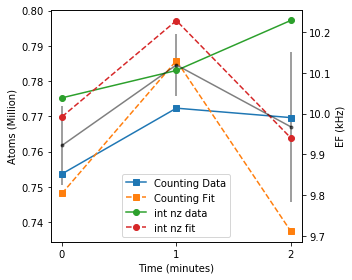

In [2117]:
# Compute total atoms and EF of the box 

# Box volume from sound data 
box_volume = (box_char['length (um)'].values[0] * 1e-6
              * np.pi*(box_char['radius (um)'].values[0] * 1e-6)**2 )

# x labels 
time = np.array(list(df_hyb_energy.time.values))
time_str = ['{:.0f}'.format(t) for t in time]
xi = df_hyb_energy.x.values
xcount = np.arange(df_hyb_energy.shape[0])

# Total Atoms from atom counting 
atoms_fit_data_ratio = np.array([r.nz_fit.y.sum()/r.nz_data.y.sum() for n,r in df_hyb_energy.iterrows()]) 
atoms_counting_data = np.array([r.image.total_atoms for n,r in df_hyb_energy.iterrows()]) 
atoms_counting_fit = atoms_counting_data * atoms_fit_data_ratio
EF_counting_data = cst.n2EF(atoms_counting_data / box_volume)
EF_counting_fit = cst.n2EF(atoms_counting_fit / box_volume)

# Total Atoms from nz integration
mult = np.pi * df_hyb_energy.iloc[0].image.pixel_binned**2
atoms_nzint_data = np.array([ np.trapz(r.nz_data.y * r.image.xsec.radius**2, r.nz_data.x)
    for n,r in df_hyb_energy.iterrows()]) * mult
atoms_nzint_fit = np.array([ np.trapz(r.nz_fit.y * r.image.xsec.radius**2, r.nz_fit.x)
    for n,r in df_hyb_energy.iterrows()]) * mult
EF_nzint_data = cst.n2EF(atoms_nzint_data / box_volume)
EF_nzint_fit = cst.n2EF(atoms_nzint_fit / box_volume)

# Average 
atoms_avg = tp.bin_data(
        np.concatenate([np.arange(len(atoms_counting_data))] * 4),
        np.concatenate([atoms_counting_data, atoms_counting_fit, 
                        atoms_nzint_data, atoms_nzint_fit]))
EF_avg = tp.bin_data(atoms_avg.xi, cst.n2EF(atoms_avg.yi/box_volume))

# Plot of atom numbers from various methods 
ax = plt.subplots(figsize=[5,4])[1]
ax = [ax]
plt.plot(atoms_counting_data/1e6, 's-', label='Counting Data', alpha=1)
plt.plot(atoms_counting_fit/1e6, 's--', label='Counting Fit', alpha=1)
plt.plot(atoms_nzint_data/1e6, 'o-', label='int nz data', alpha=1)
plt.plot(atoms_nzint_fit/1e6, 'o--', label='int nz fit', alpha=1)
plt.errorbar(atoms_avg.x, atoms_avg.y/1e6, atoms_avg.ystd/1e6, fmt='.-', color='k', alpha=0.5)
plt.legend()
plt.ylabel('Atoms (Million)')
plt.xlabel('Time (minutes)')
ax[0].set(xticks=xcount, xticklabels=time_str)
ax.append(ax[0].twinx())
ax[1].set(ylim=cst.n2EF(1e6*np.array(ax[0].get_ylim())/box_volume)/kHz, 
          ylabel='EF (kHz)')
plt.tight_layout()

if savefig.value: plt.savefig(
    suffix_energy + 'Total Atoms Various Methods.pdf')

In [2118]:
# Amount of Energy to subtract  
EN_heating_subtract = 0.1 * (3/5 * EF_avg.y.mean()) 

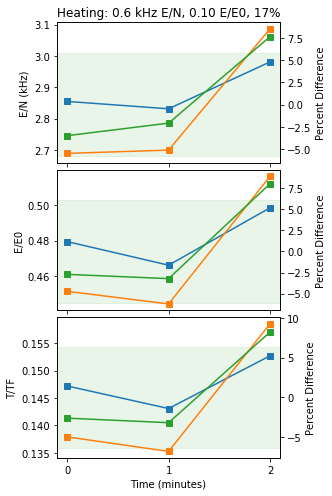

In [2119]:
# Compute E/N different ways 
EN_data = np.array([compute_moment(nz) 
           for nz in df_hyb_energy.nz_data]) - EN_heating_subtract
EN_fit = np.array([compute_moment(nz) 
           for nz in df_hyb_energy.nz_fit]) - EN_heating_subtract
EN_stitched = np.array([compute_moment(nz) 
           for nz in df_hyb_energy.nz_stitched]) - EN_heating_subtract

# Compute E/E0 
EE0_data = EN_data/(3/5 * EF_avg.y)
EE0_fit = EN_fit/(3/5 * EF_avg.y)
EE0_stitched = EN_stitched/(3/5 * EF_avg.y)

# Average E/N from fit and stitched methods 
EN_avg = tp.bin_data(np.concatenate([xi]*2), 
           np.concatenate([EN_fit, EN_stitched]))

# Compute E/E0 
EE0_avg = tp.bin_data(np.concatenate([xi]*2), 
           np.concatenate([EE0_fit, EE0_stitched]))

# Compute energy correction factors 
EN_heating_perc = 100 * EN_heating_subtract / (EN_avg.y[0] + EN_heating_subtract)
EE0_heating_subtract = EN_heating_subtract/(3/5 * EF_avg.y.mean())
EE0_heating_perc = 100 * EE0_heating_subtract / (EE0_avg.y[0] + EE0_heating_subtract)

# Compute T/TF 
c_EE0_TTF = tp.Curve(UFG.df['E/E0'].values, UFG.df['T/T_F'].values)
TTF_data = c_EE0_TTF(EE0_data)
TTF_fit = c_EE0_TTF(EE0_fit)
TTF_stitched = c_EE0_TTF(EE0_stitched)
TTF_avg = tp.bin_data(np.concatenate([xi]*2), 
           np.concatenate([TTF_fit, TTF_stitched]))

# Compute velocity 
vF_avg = (2 * EF_avg.y.mean() / cst.mass)**(1/2)
vs_avg = ((EE0_avg.y[0])/3)**(1/2) * vF_avg

# Make figure 
ax = plt.subplots(nrows=3, figsize=[4.5, 7], sharex=True)[1]
plt.sca(ax[0])
plt.plot(xcount, EN_data/kHz, 's-')
plt.plot(xcount, EN_fit/kHz, 's-')
plt.plot(xcount, EN_stitched/kHz, 's-')
plt.axhspan(EN_avg.y/kHz - EN_avg.ystd/kHz, 
            EN_avg.y/kHz + EN_avg.ystd/kHz, 
            alpha=0.1, color='C2')
ax_ = ax[0].twinx()
ax_.set(ylim = 100*(np.array(ax[0].get_ylim())/(EN_avg.y/kHz)-1),
        ylabel = 'Percent Difference')
ax[0].set(ylabel=r'E/N (kHz)', 
          xticks=xcount, xticklabels=time_str,
          title='Heating: {:.1f} kHz E/N, {:.2f} E/E0, {:.0f}%'.format(
                  EN_heating_subtract/kHz, EE0_heating_subtract, EN_heating_perc))
plt.sca(ax[1])
plt.plot(xcount, EE0_data, 's-')
plt.plot(xcount, EE0_fit, 's-')
plt.plot(xcount, EE0_stitched, 's-')
plt.axhspan(EE0_avg.y - EE0_avg.ystd, 
            EE0_avg.y + EE0_avg.ystd, 
            alpha=0.1, color='C2')
ax[1].set(ylabel=r'E/E0', 
          xticks=xcount, xticklabels=time_str)
ax_ = ax[1].twinx()
ax_.set(ylim = 100*(np.array(ax[1].get_ylim())/EE0_avg.y-1),
        ylabel = 'Percent Difference')
plt.sca(ax[2])
plt.plot(xcount, TTF_data, 's-')
plt.plot(xcount, TTF_fit, 's-')
plt.plot(xcount, TTF_stitched, 's-')
plt.axhspan(TTF_avg.y - TTF_avg.ystd, 
            TTF_avg.y + TTF_avg.ystd, 
            alpha=0.1, color='C2')
ax[2].set(ylabel=r'T/TF', xlabel=r'Time (minutes)', 
          xticks=xcount, xticklabels=time_str)
ax_ = ax[2].twinx()
ax_.set(ylim = 100*(np.array(ax[2].get_ylim())/TTF_avg.y-1),
        ylabel = 'Percent Difference')


plt.tight_layout()
plt.subplots_adjust(hspace=0.05)

if savefig.value: plt.savefig(
    suffix_energy + 'EN and EE0 Various Methods and Mean.pdf')

In [2120]:
# Store Information 
temp_info = pd.DataFrame()
temp_info['fugde'] = [df_hyb_energy.image.iloc[0].fudge]
temp_info['HeatCycles'] = df_hyb_energy['HeatCycles'].iloc[0]
temp_info['volume'] = box_volume
temp_info['total atoms'] = atoms_avg.y[0]
temp_info['total atoms error'] = atoms_avg.ystd[0]
temp_info['EF (kHz)'] = EF_avg.y[0] / kHz
temp_info['EF (kHz) error'] = EF_avg.ystd[0] / kHz
temp_info['E/N Heating (kHz)'] = EN_heating_subtract/kHz 
temp_info['E/N (kHz)'] = EN_avg.y[0] / kHz
temp_info['E/N (kHz) error'] = EN_avg.ystd[0] / kHz
temp_info['E/E0'] = EE0_avg.y[0]
temp_info['E/E0 error'] = EE0_avg.ystd[0]
temp_info['T/TF'] = TTF_avg.y[0]
temp_info['T/TF error'] = TTF_avg.ystd[0]
temp_info['v (m/s)'] = vs_avg
if savefig.value: temp_info.to_excel(suffix + 'ThermoInfo.xlsx')
temp_info

,fugde,HeatCycles,volume,total atoms,total atoms error,EF (kHz),EF (kHz) error,E/N Heating (kHz),E/N (kHz),E/N (kHz) error,E/E0,E/E0 error,T/TF,T/TF error,v (m/s)
0,1.86,0.0,1.111234e-12,761749.129621,11163.327222,9.923555,0.096958,0.600265,2.844698,0.165545,0.473994,0.028798,0.145092,0.009176,0.014482


## Results

In [2121]:
# Print highlights 
print('EF   : {:.2f} +/- {:.2f} kHz'.format(temp_info['EF (kHz)'].values[0], temp_info['EF (kHz) error'].values[0]))
print('E/E0 : {:.2f} +/- {:.2f}'.format(temp_info['E/E0'].values[0], temp_info['E/E0 error'].values[0]))
print('T/TF : {:.2f} +/- {:.2f}'.format(temp_info['T/TF'].values[0], temp_info['T/TF error'].values[0]))
print('v    : {:.1f} mm/s'.format(temp_info['v (m/s)'].values[0] * 1e3))

EF   : 9.92 +/- 0.10 kHz
E/E0 : 0.47 +/- 0.03
T/TF : 0.15 +/- 0.01
v    : 14.5 mm/s


In [2122]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

# Condensate Fraction from Rapid Ramp

## Bunch of Calcs

In [2009]:
# Function definition for cond frac 
def get_cond_frac(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(tp.gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, tp.gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[1]

# Function definition for cond frac 
def get_cond_frac(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(tp.gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, tp.gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.title(r'Gaussian Thermal Fit $N_c=${:.2f}'.format(cond_frac))
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[1]

def g_3half_fitfun(x, x0, mu, kt, n0, offset=0):
    return (1/(2*np.pi*kt)**(3/2))*n0* mpmath.fp.polylog(3/2,np.exp(-np.abs(((x-x0)**2)/2 + np.abs(mu))/kt )) + offset

g32 = np.vectorize(g_3half_fitfun)

def get_cond_frac_polylog(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    fr = c_.fit(g32, [c_.maxx/2, 0.1, 1e3, 4e8,0], plot=False)[0]
    x, y = c.x, c.y - fr[4]
    fr[4] = 0
    xf, yf = x, g32(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(app)
        plt.axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        plt.axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        plt.subplot(122)
        plt.title(r'Polylog Thermal Fit $N_c=${:.2f}'.format(cond_frac))
        plt.plot(*c.plotdata)
        plt.plot(*c_.xyfitplot)
        plt.axvline(thermal_limits[0], color='r', linestyle='--', alpha=0.3)
        plt.axvline(thermal_limits[1], color='r', linestyle='--', alpha=0.3)
        plt.xlim([fr[0] - plot_width, fr[0] + plot_width])
        plt.tight_layout()

    return cond_frac, fr[2]

def get_cond_frac_mixed(app, thermal_limits, plot=False, plot_width=50):
    c = tp.Curve(y = np.nansum(app, axis=1))
    using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
    c_ = tp.Curve(x = c.x[using], y = c.y[using])
    
    # first fit a tp.gaussian
    fr = c_.fit(tp.gaussian, [c_.maxx/2, c_.maxx/8, c_.maxy, c_.maxy/1000], plot=False)[0]
    x, y = c.x, c.y - fr[3]
    fr[3] = 0
    xf, yf = x, tp.gaussian(x, *fr)
    cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
    fit_method = 'Gaussian'
    Tstar = fr[1]
    c_fit = c_
    
    # if it's narrow enough, fit a polylog
    if fr[1] <= 39:
        c_p = tp.Curve(x = c.x[using], y = c.y[using])
        fr = c_p.fit(g32, [c_p.maxx/2, 1e3, 1e3, 5e8,0], plot=False)[0]
        x, y = c.x, c.y - fr[4]
        fr[4] = 0
        xf, yf = x, g32(x, *fr)
        cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
        fit_method = 'PolyLog'
        Tstar = fr[2]
        c_fit = c_p
        
    if cond_frac>0.3:
        # expand thermal limits for large condensates
        thermal_limits = np.array(thermal_limits)+[-5,5]
        using = (c.x <= thermal_limits[0]) | (c.x >= thermal_limits[1])
        c_p = tp.Curve(x = c.x[using], y = c.y[using])
        fr = c_p.fit(g32, [c_p.maxx/2,1e3, 1e3, 5e8,0], plot=False)[0]
        x, y = c.x, c.y - fr[4]
        fr[4] = 0
        xf, yf = x, g32(x, *fr)
        cond_frac = (np.trapz(y, x) - np.trapz(yf, xf))/ np.trapz(y, x)
        fit_method = 'PolyLog'
        Tstar = fr[2]
        c_fit = c_p
        

    
    if plot:
        fig, axarr = plt.subplots(ncols=2, figsize=(10,4))
        axarr[0].imshow(app)
        axarr[0].axhline(thermal_limits[0], color='w', linestyle='--', alpha=0.5)
        axarr[0].axhline(thermal_limits[1], color='w', linestyle='--', alpha=0.5)
        axarr[0].set_title('Raw Rapid Ramp')
        
        axarr[1].set(title=r'$N_c=${:.2f}'.format(cond_frac), xlim=[fr[0] - plot_width, fr[0] + plot_width])
        axarr[1].plot(*c.plotdata,'r-', linewidth=2, alpha=0.6, label='data')
        axarr[1].plot(*c_.xyfitplot, 'k--', alpha=0.5, linewidth=1 , label='Gaussian thermal fit')
        if fit_method=='PolyLog':
            axarr[1].plot(*c_p.xyfitplot, 'k-', linewidth=1 , label='Polylog thermal fit')
            
        axarr[1].axvspan(*thermal_limits, alpha=0.05, color='k', label='Excluded from fit')
        plt.legend()
        plt.tight_layout()
        
    
        
    return cond_frac, Tstar, c_fit, c



In [2010]:
df_rr_all = pd.DataFrame()

In [2011]:
# Relevant Parameters 
x_var_name = ['BoxShakeFreq', 'BoxShakeAmp', 'ShakingCycles','HeatCycles']
x_var_label = [r'$\nu$ (Hz)', 'Amplitude (V)', 'Cycles (#)','Heat Cycles (#)']
usei = 3
x_var_name, x_var_label = x_var_name[usei], x_var_label[usei]
image_use = 'A'

In [2012]:
# Import from Clipboard 
df_rr_all = tp.images_from_clipboard(df=df_rr_all,
                                 x=x_var_name, 
                                 params=import_params,
                                 image_func=tp.Image,
                                 download=image_use,
                                 display=True)

Updating the local database...
Done

Total Number of Shots 3, Images 3


,time,image,A,B,S,download,ExpansionTime,SideGreenEvap,WaitBox,IREvap,...,ShakingCycles2,BoxShakeFreq2,BoxShakeTime2,BoxShakeAmp2,SeqMode,GradientOffset,GradientShakeAmp,GradientShakeFreq,GradientShakeCycle,x
name,,,,,,,,,,,,,,,,,,,,,
07-05-2018_21_37_32_TopA,0.000000,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0
07-05-2018_21_38_55_TopA,1.383333,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0
07-05-2018_21_39_50_TopA,2.300000,Image object,True,False,False,True,2000.0,0.4,0.5,0.8,...,None,None,None,None,None,5.0,0.25,65.0,0.0,0.0


In [2013]:
# Start a figure folder 
display(savefig)
suffix_rr = os.path.join(folder_name, 'CondFrac','')
os.makedirs(os.path.join(suffix_rr), exist_ok=True)
suffix_rr

'07-05-2018_20_24_BoxShaking\\CondFrac\\'

In [2035]:
# Define Settings 
settings = {**default_settings, 
            **dict(center_x = 1200, center_y = 1350, width=1000, height=600, rotate=5)}

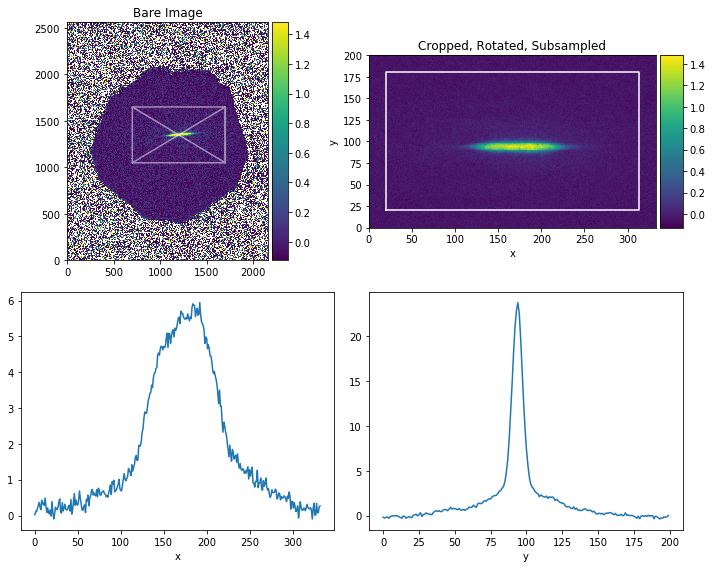

In [2036]:
# Verify Settings 

# Apply to all Images 
for n,r in df_rr_all.iterrows(): r.image.set(**settings)
    
# Function to plot the restults 
def temp(test=np.random.randint(0, df_rr_all.shape[0])):
    r = df_rr_all.iloc[test]
    ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))[1].flatten()
    r.image.plot_crop(ax=ax[0:2])
    ax[1].set(xlabel='x', ylabel='y')
    ax[2].plot(np.nanmean(r.image.app, axis=0))
    ax[3].plot(np.nanmean(r.image.app, axis=1))
    ax[2].set(xlabel='x')
    ax[3].set(xlabel='y')
    plt.tight_layout()
    if savefig.value: plt.savefig(suffix_samples + 'RapidRamp Sample {}.pdf'.format(r.name[11:16]))

if df_rr_all.shape[0] == 1: temp(0)
else: ipywidgets.interact(temp, test=(0, df_rr_all.shape[0]-1))


Total Images 3 ==> Good 3, Bad 0


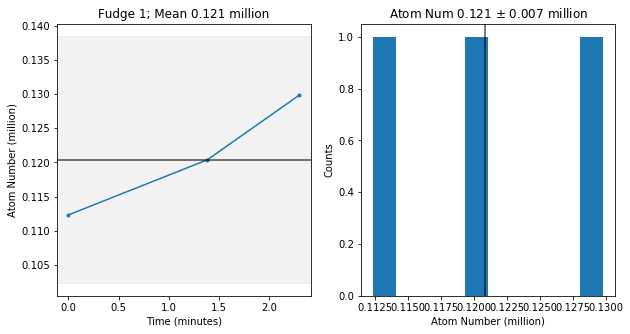

In [2037]:
# Atom Number Filter 
df_rr_all['total_atoms'] = [im.total_atoms for im in tqdm(df_rr_all.image)]
ax = tp.atom_num_filter(df=df_rr_all, keep=0.15, offset=0.0, display=True, plot=True)
# ax[0].set(ylim=[0.3,None])
if savefig.value: plt.savefig(suffix_rr + 'AtomNumbersScatter.pdf')
df_rr = df_rr_all[df_rr_all.use]

Condensate Fraction 0.54 for x_var 0.0


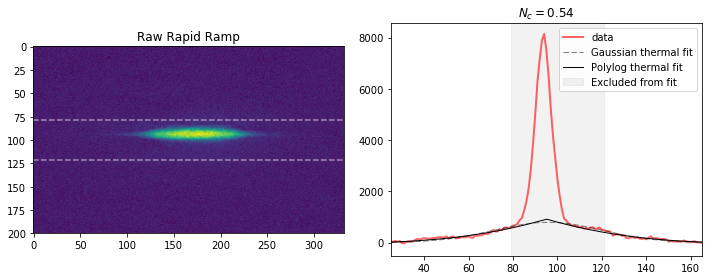

In [2038]:
# Condensate Fraction sampler 
cond_frac_center = df_rr.image.iloc[0].app.shape[0]//2 - 0
width = 16
plot_width = 70
thermal_limits = [cond_frac_center - width, cond_frac_center + width]

def temp_func(test = 0):
    #cond_frac, sigma = get_cond_frac(df_rr.image.iloc[test].app, thermal_limits, True, plot_width)
    cond_frac, Tstar, c_fit, c = get_cond_frac_mixed(df_rr.image.iloc[test].app, thermal_limits, True, plot_width)
    print('Condensate Fraction {:.2f} for x_var {}'.format(cond_frac, df_rr.x.iloc[test]))
    plt.savefig(suffix_rr + 'CondFrac_{}_{}.pdf'.format(df_rr.x.iloc[test], df_rr.index.values[test]))

if df_rr.shape[0]==1:
    temp_func(0)
else:
    ipywidgets.interact(temp_func, test=(0, df_rr.shape[0]-1, 1));

In [2039]:
# Fit for cond frac 
fit_results = [get_cond_frac_mixed(im.app, thermal_limits) for im in tqdm(df_rr.image)]
fit_results = np.array(fit_results)
df_rr['cond_frac'] = fit_results[:,0] 
df_rr['sigma'] = fit_results[:, 1] * df_rr.image.iloc[0].pixel_binned * 1e6 # in um
df_rr['Tstar'] = df_rr['sigma']**2 / 1e6 # Arbitrary normalization 

In [2040]:
# Bin Data & Save Data 
Nc_bin = tp.bin_data(df_rr.x.values, df_rr.cond_frac.values)
Tstar_bin = tp.bin_data(df_rr.x.values, df_rr.Tstar.values)
atoms_bin = tp.bin_data(df_rr.x.values, df_rr.total_atoms.values/1e6)

# Save Data 
condinfo = df_rr[['time', 'x', 'total_atoms', 'cond_frac', 'sigma', 'Tstar']]
condinfo.to_excel(suffix + 'CondFracInfo.xlsx')

## Results

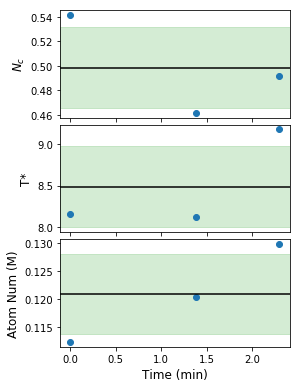

In [2041]:
# Plot vs Time 
time = df_rr.time.values

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=[4, 5.2])
plt.sca(ax[0])
plt.plot(time, Nc_bin.yi, 'o')
plt.axhline(Nc_bin.y, color='k')
plt.axhspan(Nc_bin.y-Nc_bin.ystd, Nc_bin.y+Nc_bin.ystd, alpha=0.2, color='C2')
plt.ylabel(r'$N_c$', fontsize=12)
plt.sca(ax[1])
plt.plot(time, Tstar_bin.yi, 'o')
plt.axhline(Tstar_bin.y, color='k')
plt.axhspan(Tstar_bin.y-Tstar_bin.ystd, Tstar_bin.y+Tstar_bin.ystd, alpha=0.2, color='C2')
plt.ylabel(r'T*', fontsize=12)
plt.sca(ax[2])
plt.plot(time, atoms_bin.yi, 'o')
plt.axhline(atoms_bin.y, color='k')
plt.axhspan(atoms_bin.y-atoms_bin.ystd, atoms_bin.y+atoms_bin.ystd, alpha=0.2, color='C2')
plt.ylabel(r'Atom Num (M)', fontsize=12)
plt.xlabel('Time (min)', fontsize=12)
plt.tight_layout(pad=0)
plt.savefig(suffix_rr + 'CondFrac vs Time.pdf')

In [2042]:
# Copy the file 
if savefig.value:
    shutil.copyfile(getNotebookName(), suffix + 'BoxShakingAnalyzer.ipynb')

<IPython.core.display.Javascript object>

In [247]:
1 / (9*kHz * 2 * cst.mass / cst.hbar**2)**(1/2) /(0.529e-10)

5775.763862430879

In [256]:
twopi/cst.EFHz2kF(10000)

1.8212359912665147e-06